<a href="https://www.kaggle.com/code/marinanasser/image-processing-project-3?scriptVersionId=288944197" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [57]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-segmentation-brats-2019/MICCAI_BraTS_2019_Data_Training/name_mapping.csv
/kaggle/input/brain-tumor-segmentation-brats-2019/MICCAI_BraTS_2019_Data_Training/survival_data.csv
/kaggle/input/brain-tumor-segmentation-brats-2019/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_27_1/BraTS19_2013_27_1_seg.nii
/kaggle/input/brain-tumor-segmentation-brats-2019/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_27_1/BraTS19_2013_27_1_t1.nii
/kaggle/input/brain-tumor-segmentation-brats-2019/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_27_1/BraTS19_2013_27_1_t1ce.nii
/kaggle/input/brain-tumor-segmentation-brats-2019/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_27_1/BraTS19_2013_27_1_flair.nii
/kaggle/input/brain-tumor-segmentation-brats-2019/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_27_1/BraTS19_2013_27_1_t2.nii
/kaggle/input/brain-tumor-segmentation-brats-2019/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_CBICA_AQA_1/BraTS19_CBICA_AQA_1_flair.nii
/kaggle/input/

# Configuration 


In [2]:
import tensorflow as tf
import numpy as np
import nibabel as nib
import os
from glob import glob
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim


IMG_WIDTH = 256
IMG_HEIGHT = 256
BATCH_SIZE = 4
BUFFER_SIZE = 400
EPOCHS = 100
LAMBDA = 100
PATIENT_LIMIT = 10 

BRAIN_DATA_DIR = '/kaggle/input/brain-tumor-segmentation-brats-2019/MICCAI_BraTS_2019_Data_Training'


2025-12-28 20:01:37.424769: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766952097.601779      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766952097.653251      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [3]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Visualize sample data slices
def visualize_sample_data(train_ds, num_samples=3):
    """Visualize sample input and target pairs from the dataset."""
    plt.figure(figsize=(15, 5 * num_samples))
    
    for i, (input_img, target_img) in enumerate(train_ds.take(num_samples)):
        # Denormalize from [-1, 1] to [0, 1]
        input_display = (input_img[0].numpy().squeeze() + 1) / 2
        target_display = (target_img[0].numpy().squeeze() + 1) / 2
        
        # Input image
        plt.subplot(num_samples, 2, i*2 + 1)
        plt.imshow(input_display, cmap='gray')
        plt.title(f'Input Image {i+1} (T2)')
        plt.axis('off')
        
        # Target image
        plt.subplot(num_samples, 2, i*2 + 2)
        plt.imshow(target_display, cmap='gray')
        plt.title(f'Target Image {i+1} (T1)')
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('sample_data_pairs.png', dpi=150, bbox_inches='tight')
    plt.show()

In [60]:
def generate_images(model, test_input, tar, save_filename=None):
    """Generate and display predictions."""
    prediction = model(test_input, training=False)
    
    plt.figure(figsize=(15, 5))
    
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image (T2)', 'Ground Truth (T1)', 'Predicted Image (T1)']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        # Denormalize from [-1, 1] to [0, 1]
        img = (display_list[i].numpy().squeeze() + 1) / 2
        plt.imshow(img, cmap='gray')
        plt.title(title[i])
        plt.axis('off')
    
    if save_filename:
        plt.savefig(save_filename, dpi=150, bbox_inches='tight')
    plt.show()


In [5]:
def fit_with_visualization(train_ds, test_ds, epochs, generator, discriminator):
    """Training loop with visualization and metrics tracking."""
    print(f"Starting training for {epochs} epochs...")
    
    # Get a sample for visualization
    # Change this line inside fit_with_visualization
    example_input, example_target = next(iter(test_ds.take(1)))
    
    # Lists to store metrics
    psnr_history = []
    ssim_history = []
    
    for epoch in range(epochs):
        # TRAIN
        for n, (input_image, target) in train_ds.enumerate():
            if n % 100 == 0:
                print(f'\rEpoch {epoch + 1}/{epochs} | Step {n}', end='')
            train_step(input_image, target, generator, discriminator)
        
        # EVALUATE
        avg_psnr, avg_ssim = calculate_metrics(test_ds, generator)
        psnr_history.append(avg_psnr)
        ssim_history.append(avg_ssim)
        
        print(f'\n--- Epoch {epoch + 1} Evaluation ---')
        print(f'PSNR: {avg_psnr:.2f}')
        print(f'SSIM: {avg_ssim:.4f}')
        print('-' * 40)
        
        # Visualize predictions every 5 epochs
        if (epoch + 1) % 5 == 0:
            generate_images(generator, example_input, example_target, 
                          f'prediction_epoch_{epoch+1}.png')
    
    return psnr_history, ssim_history


# plot training metrics
def plot_training_metrics(psnr_history, ssim_history):
    """Plot PSNR and SSIM over epochs."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs_range = range(1, len(psnr_history) + 1)
    
    # PSNR plot
    ax1.plot(epochs_range, psnr_history, 'b-', linewidth=2, marker='o')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('PSNR (dB)', fontsize=12)
    ax1.set_title('Peak Signal-to-Noise Ratio over Epochs', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # SSIM plot
    ax2.plot(epochs_range, ssim_history, 'r-', linewidth=2, marker='s')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('SSIM', fontsize=12)
    ax2.set_title('Structural Similarity Index over Epochs', fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_metrics.png', dpi=150, bbox_inches='tight')
    plt.show()

def evaluate_and_visualize(test_ds, generator, num_samples=5):
    """Evaluate model and create comprehensive visualization."""
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    
    all_psnr = []
    all_ssim = []
    
    for idx, (input_image, real_target) in enumerate(test_ds.take(num_samples)):
        # Generate prediction
        synthetic_image = generator(input_image, training=False)
        
        # Denormalize
        input_display = (input_image[0].numpy().squeeze() + 1) / 2
        real_display = (real_target[0].numpy().squeeze() + 1) / 2
        synthetic_display = (synthetic_image[0].numpy().squeeze() + 1) / 2
        
        # Calculate metrics
        p = psnr(real_display, synthetic_display, data_range=1.0)
        s = ssim(real_display, synthetic_display, data_range=1.0, channel_axis=None)
        all_psnr.append(p)
        all_ssim.append(s)
        
        # Calculate difference map
        diff = np.abs(real_display - synthetic_display)
        
        # Plot
        axes[idx, 0].imshow(input_display, cmap='gray')
        axes[idx, 0].set_title(f'Input (T2)')
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(real_display, cmap='gray')
        axes[idx, 1].set_title(f'Ground Truth (T1)')
        axes[idx, 1].axis('off')
        
        axes[idx, 2].imshow(synthetic_display, cmap='gray')
        axes[idx, 2].set_title(f'Generated (T1)\nPSNR: {p:.2f} dB')
        axes[idx, 2].axis('off')
        
        axes[idx, 3].imshow(diff, cmap='hot')
        axes[idx, 3].set_title(f'Difference Map\nSSIM: {s:.4f}')
        axes[idx, 3].axis('off')
    
    plt.tight_layout()
    plt.savefig('comprehensive_evaluation.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nAverage PSNR: {np.mean(all_psnr):.2f} dB")
    print(f"Average SSIM: {np.mean(all_ssim):.4f}")

def analyze_data_distribution(train_ds):
    """Analyze and visualize the distribution of pixel intensities."""
    input_pixels = []
    target_pixels = []
    
    for input_img, target_img in train_ds.take(100):
        input_pixels.extend(input_img.numpy().flatten())
        target_pixels.extend(target_img.numpy().flatten())
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Input distribution
    axes[0].hist(input_pixels, bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[0].set_xlabel('Pixel Intensity', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].set_title('Input Image (T2) Pixel Distribution', fontsize=14)
    axes[0].grid(True, alpha=0.3)
    
    # Target distribution
    axes[1].hist(target_pixels, bins=50, alpha=0.7, color='red', edgecolor='black')
    axes[1].set_xlabel('Pixel Intensity', fontsize=12)
    axes[1].set_ylabel('Frequency', fontsize=12)
    axes[1].set_title('Target Image (T1) Pixel Distribution', fontsize=14)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('data_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()


# U-Net/PatchGAN Helper Blocks

In [6]:

def downsample(filters, size, apply_batchnorm=True):
    """Downsampling block for the U-Net Encoder."""
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    """Upsampling block for the U-Net Decoder."""
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())
    return result

# Model Definition (Pix2Pix)
## Pix2Pix uses a U-Net as its Generator and a PatchGAN as its Discriminator.

### A. Generator (U-Net)
The Generator takes the input image (e.g., T1) and tries to output the target image (e.g., T2).
### B. Discriminator (PatchGAN)
The Discriminator tries to distinguish between a real image pair (T1, Real T2) and a fake image pair (T1, Synthetic T2).

In [7]:
def Generator():
    """Defines the U-Net Generator model."""
    inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 1])

    # Encoder (Downsampling)
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
        downsample(512, 4),  # (bs, 8, 8, 512)
        downsample(512, 4),  # (bs, 4, 4, 512)
        downsample(512, 4),  # (bs, 2, 2, 512)
        downsample(512, 4),  # (bs, 1, 1, 512)
    ]

    # Decoder (Upsampling)
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4),                      # (bs, 16, 16, 1024)
        upsample(256, 4),                      # (bs, 32, 32, 512)
        upsample(128, 4),                      # (bs, 64, 64, 256)
        upsample(64, 4),                       # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same',
                                          kernel_initializer=initializer,
                                          activation='tanh')  # (bs, 256, 256, 1)

    x = inputs
    skips = []
    
    # Downsampling layers
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1]) # Skip the bottleneck output itself
    
    # Upsampling layers and skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [8]:
!which dot
import pydot
import graphviz

# Create a simple graph
graph = pydot.Dot(graph_type='digraph')
graph.add_node(pydot.Node("A"))
graph.add_node(pydot.Node("B"))
graph.add_edge(pydot.Edge("A", "B"))

# Save to PNG
graph.write_png("test_graph.png")
print("Graphviz works! Check test_graph.png")


/usr/bin/dot
Graphviz works! Check test_graph.png


I0000 00:00:1766952136.108132      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


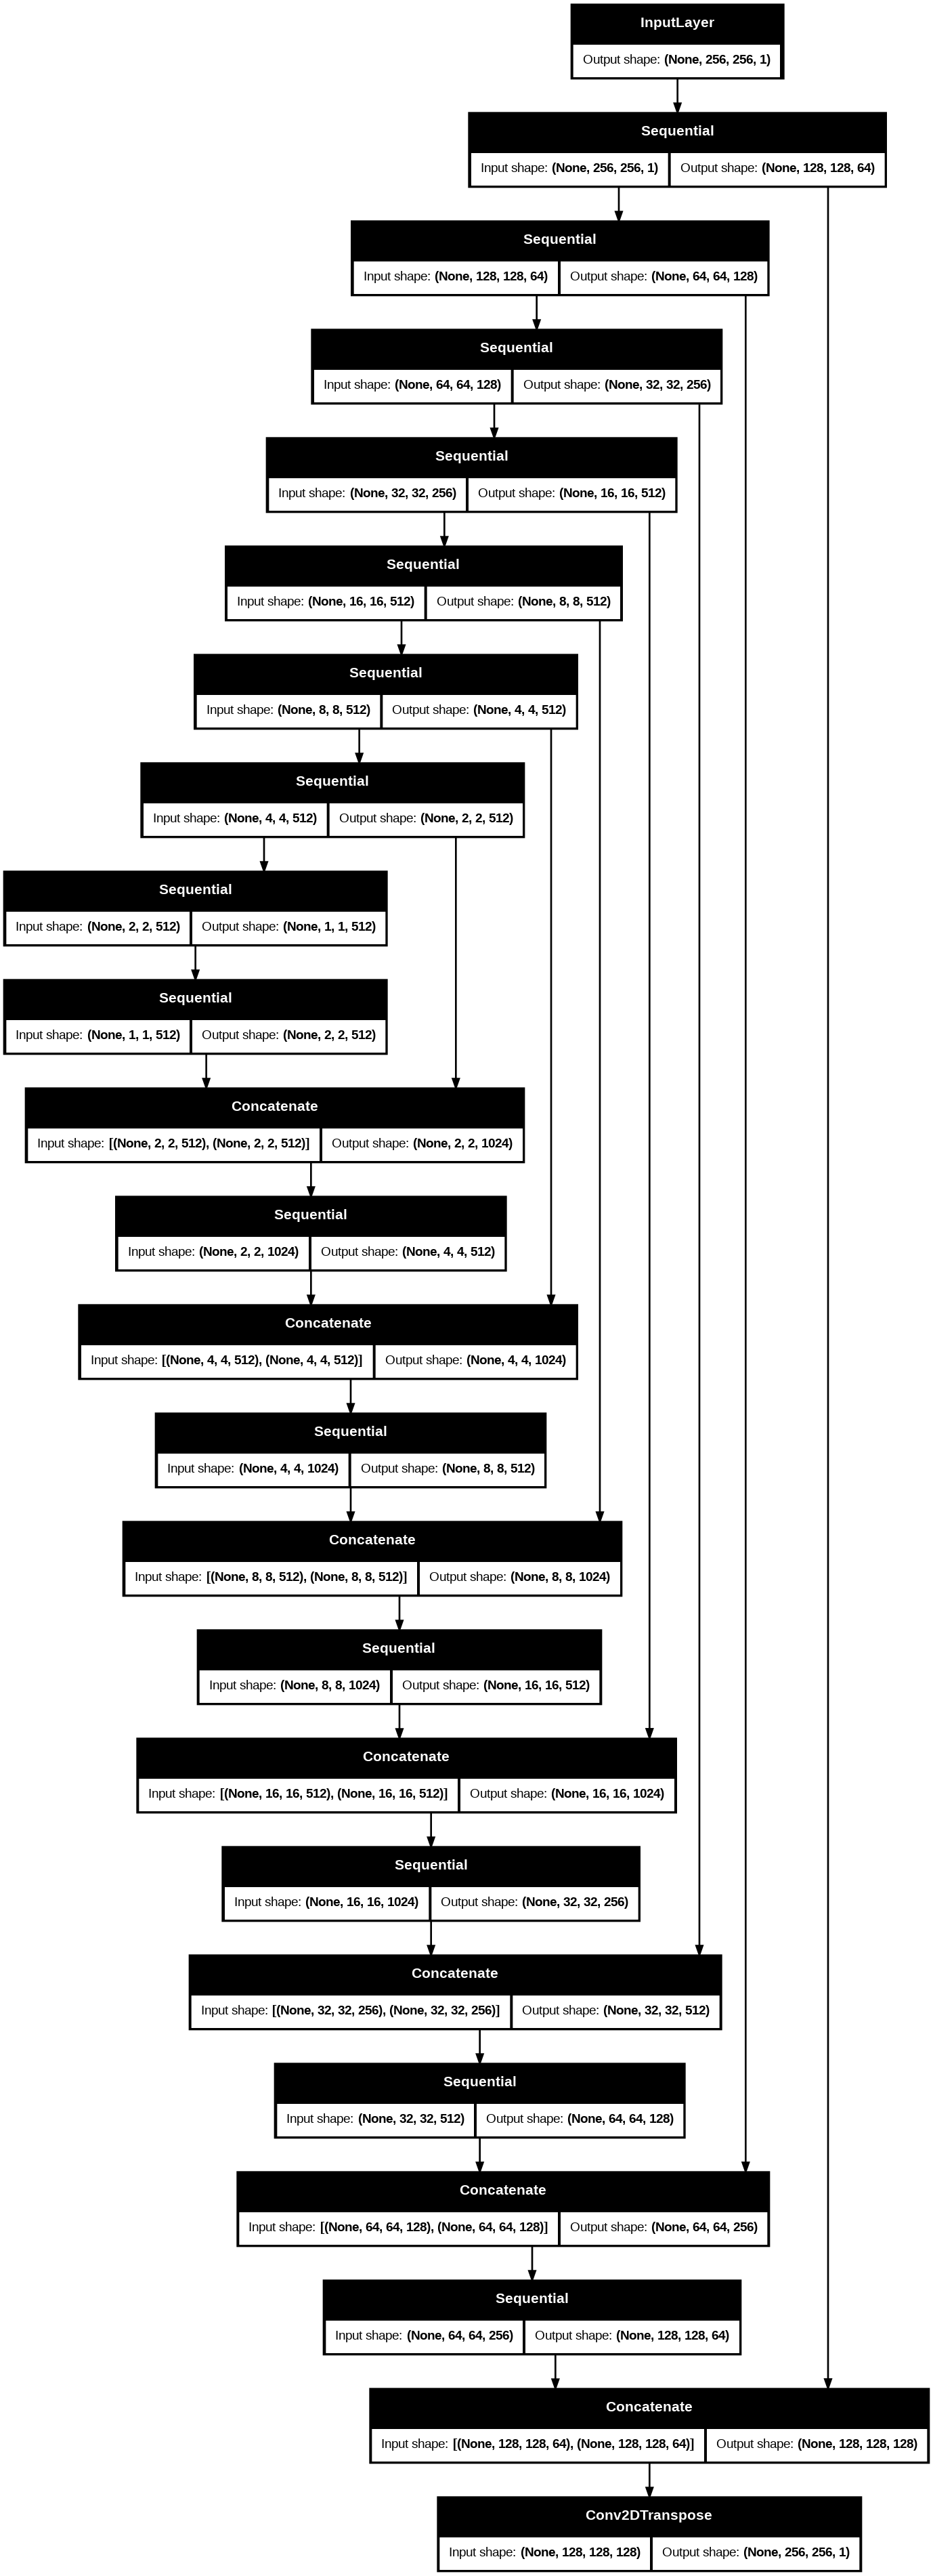

In [9]:
from tensorflow.keras.utils import plot_model

generator = Generator()
plot_model(generator, show_shapes=True, to_file='generator_architecture.png', dpi=96)

In [10]:
def Discriminator():
    """Defines the PatchGAN Discriminator model."""
    initializer = tf.random_normal_initializer(0., 0.02)

    # Input (e.g., T1)
    inp = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 1], name='input_image')
    # Target (e.g., Real T2 or Fake T2)
    tar = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 1], name='target_image')

    # Concatenate Input and Target along the channel axis
    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, 2)

    # C64
    down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
    # C128
    down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
    # C256
    down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)

    # C512
    # Downsample again, but use a stride of 1
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    # Output (A single value per patch)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

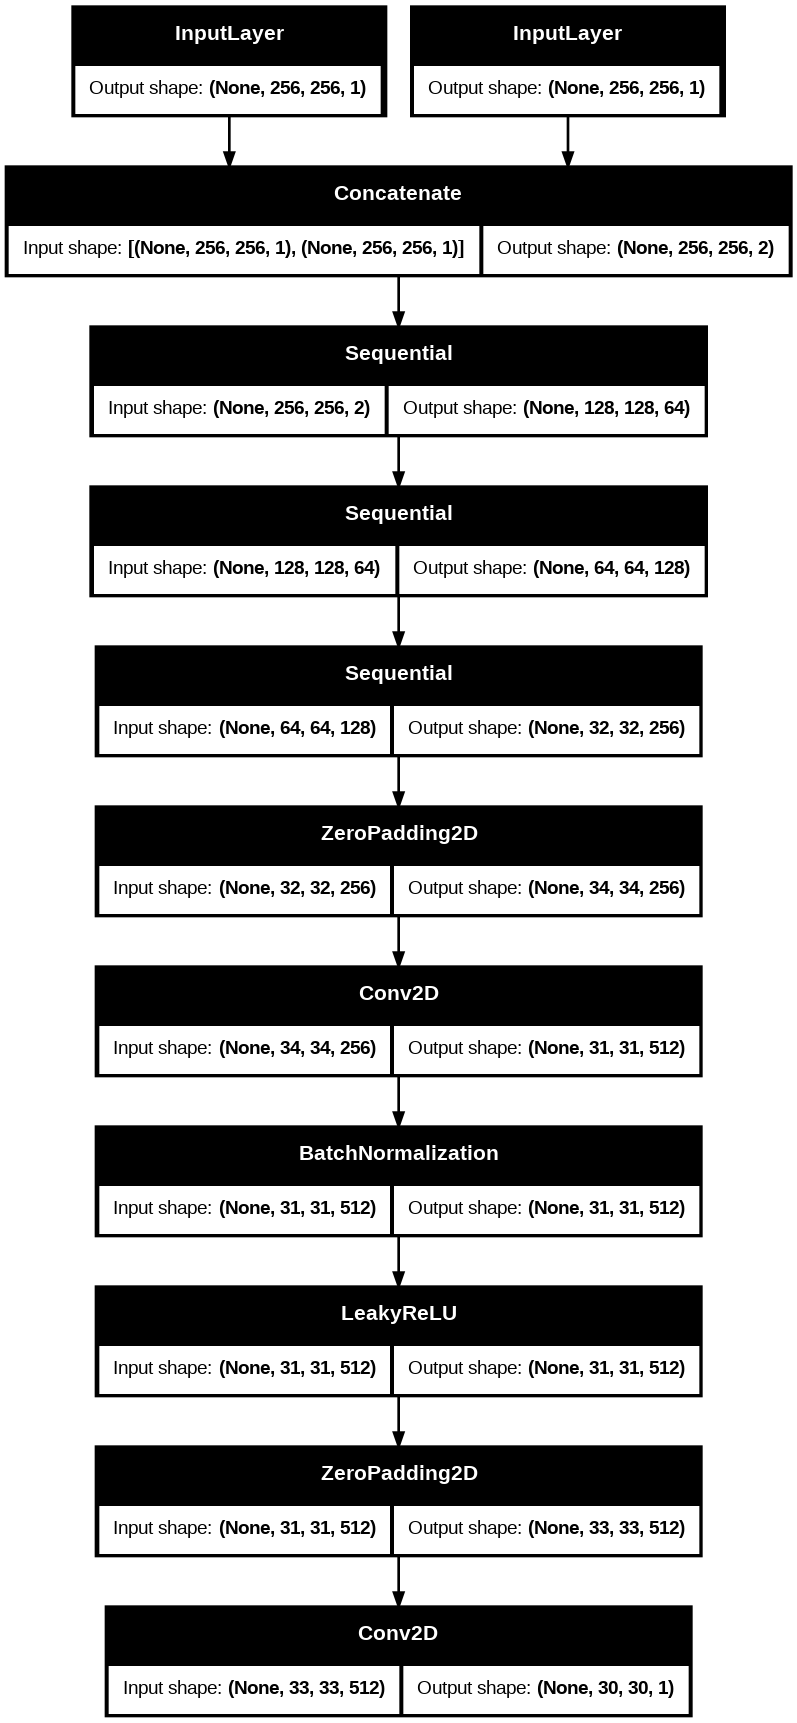

In [11]:
discriminator = Discriminator()
plot_model(discriminator, show_shapes=True, to_file='discriminator_architecture.png', dpi=96)

When running the create_dataset function, we are loading all selected 3D NIfTI volumes, extracting all 2D slices, and storing them as massive NumPy arrays (input_array and target_array) in our computer's main memory (RAM). Since there are many patients (volumes) and each volume yields 155 or more 256x256 slices, the total number of 2D slices quickly consumes all available RAM.

so i put a limit


In [12]:
def load_nifti_to_slices(file_path):
    try:
        img = nib.load(file_path)
        data = img.get_fdata().astype(np.float32)

        # Robust intensity normalization (FIX)
        p1, p99 = np.percentile(data, (1, 99))
        data = np.clip(data, p1, p99)
        data = (data - p1) / (p99 - p1 + 1e-7)  # [0,1]

        slices = [data[:, :, i] for i in range(data.shape[2])]
        return np.stack(slices, axis=0)

    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return np.empty((0, 256, 256), dtype=np.float32)



def create_dataset(data_dir, task='t1_to_t2', max_patients=None): # <--- MAX PATIENTS ADDED
    """
    Finds paired T1 and T2 volumes, limits processing to max_patients, 
    and creates a tf.data.Dataset.
    """
    
    # 1. Corrected File Search (.nii extension confirmed from previous step)
    search_pattern = os.path.join(data_dir, '*/*/*t*.nii')
    all_files = glob(search_pattern, recursive=False)
    
    # Filter and sort the T1 and T2 files
    t1_files = sorted([f for f in all_files if f.endswith('t1.nii') and 't1ce' not in f])
    t2_files = sorted([f for f in all_files if f.endswith('t2.nii')])
    
    # Ensure lists are the same length for zipping (should be handled by BraTS structure)
    min_files = min(len(t1_files), len(t2_files))
    
    # --- Apply Patient Limit ---
    if max_patients is not None:
        min_files = min(min_files, max_patients)
    
    t1_files = t1_files[:min_files]
    t2_files = t2_files[:min_files]
    
    print(f"\nProcessing {min_files} patients out of {min(len(t1_files), len(t2_files))} potential pairs.")

    all_input_slices = []
    all_target_slices = []

    # 2. Pair and Process
    for t1_path, t2_path in zip(t1_files, t2_files):
        
        t1_slices = load_nifti_to_slices(t1_path)
        t2_slices = load_nifti_to_slices(t2_path)
        
        if t1_slices.size == 0 or t2_slices.size == 0:
            continue
            
        # ... (rest of the slice processing logic) ...
        min_slices = min(t1_slices.shape[0], t2_slices.shape[0])

        if task == 't1_to_t2':
            all_input_slices.append(t1_slices[:min_slices])
            all_target_slices.append(t2_slices[:min_slices])
        elif task == 't2_to_t1':
            all_input_slices.append(t2_slices[:min_slices])
            all_target_slices.append(t1_slices[:min_slices])

    # 3. Concatenate and Split
    if not all_input_slices:
        raise ValueError("After processing, no valid slices remain to concatenate. Dataset is empty.")
        
    input_array = np.concatenate(all_input_slices, axis=0)[..., np.newaxis].astype(np.float32)
    target_array = np.concatenate(all_target_slices, axis=0)[..., np.newaxis].astype(np.float32)

    print(f"Total paired slices created for {task}: {input_array.shape[0]}")
    
    # ... (rest of the splitting logic) ...
    data_size = input_array.shape[0]
    train_size = int(0.9 * data_size)
    
    train_input = input_array[:train_size]
    train_target = target_array[:train_size]
    test_input = input_array[train_size:]
    test_target = target_array[train_size:]

    train_ds = tf.data.Dataset.from_tensor_slices((train_input, train_target))
    test_ds = tf.data.Dataset.from_tensor_slices((test_input, test_target))
    
    return train_ds, test_ds

# Preprocessing functions


In [13]:
def resize(image, height, width):
    return tf.image.resize(image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

def normalize(input_image, real_image):
    # Scale from [0, 1] to [-1, 1]
    input_image = (input_image * 2.0) - 1.0
    real_image = (real_image * 2.0) - 1.0
    
    # Add clipping to ensure strict bounds
    input_image = tf.clip_by_value(input_image, -1.0, 1.0)
    real_image = tf.clip_by_value(real_image, -1.0, 1.0)
    
    return input_image, real_image
@tf.function()
def random_jitter(input_image, real_image):
    # Resizing to 286x286
    input_image = resize(input_image, 286, 286)
    real_image = resize(real_image, 286, 286)

    # Random cropping back to 256x256
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
        stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 1])

    input_image, real_image = cropped_image[0], cropped_image[1]

    if tf.random.uniform(()) > 0.5:
        # Random mirroring (Horizontal flip)
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

def load_image_train(input_image, real_image):
    input_image, real_image = normalize(input_image, real_image)
    input_image, real_image = random_jitter(input_image, real_image)
    return input_image, real_image

def load_image_test(input_image, real_image):
    input_image, real_image = normalize(input_image, real_image)
    input_image = resize(input_image, IMG_HEIGHT, IMG_WIDTH)
    real_image = resize(real_image, IMG_HEIGHT, IMG_WIDTH)
    return input_image, real_image

# Loss Functions and Optimization

In [14]:
# --- Loss Functions and Optimizers ---
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    fake_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + fake_loss
    return total_disc_loss

def generator_loss(disc_generated_output, gen_output, target):
    # Adversarial Loss (GAN Loss)
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    
    # L1 Loss (Image fidelity)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    
    # Total Generator loss
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# --- Training Step ---
def train_step(input_image, target, generator, discriminator):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                 discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                discriminator.trainable_variables))

# --- Evaluation Metrics ---

def calculate_metrics(test_ds, generator):
    all_psnr = []
    all_ssim = []

    for input_image, real_target in test_ds:
        # Generate the synthetic image
        synthetic_image = generator(input_image, training=False)
        
        # Denormalize from [-1, 1] to [0, 1] for metrics calculation
        synthetic_image = (synthetic_image[0].numpy().squeeze() + 1) / 2
        real_target = (real_target[0].numpy().squeeze() + 1) / 2
        
        # Calculate PSNR (data_range=1.0 for normalized image)
        p = psnr(real_target, synthetic_image, data_range=1.0)
        all_psnr.append(p)

        # Calculate SSIM (channel_axis=None for grayscale 2D image)
        s = ssim(real_target, synthetic_image, data_range=1.0, channel_axis=None)
        all_ssim.append(s)

    avg_psnr = np.mean(all_psnr)
    avg_ssim = np.mean(all_ssim)
    
    return avg_psnr, avg_ssim

# --- Main Training Loop ---

def fit(train_ds, test_ds, epochs, generator, discriminator):
    print(f"Starting training for {epochs} epochs...")
    
    for epoch in range(epochs):
        # TRAIN
        for n, (input_image, target) in train_ds.enumerate():
            if n % 100 == 0:
                 print(f'\rEpoch {epoch + 1}/{epochs} | Step {n}', end='')
            train_step(input_image, target, generator, discriminator)
            
        # EVALUATE
        avg_psnr, avg_ssim = calculate_metrics(test_ds, generator)
        print(f'\n--- Epoch {epoch + 1} Evaluation ---')
        print(f'PSNR: {avg_psnr:.2f}')
        print(f'SSIM: {avg_ssim:.4f}')
        print('-' * 40)

In [15]:
# Add these visualization cells to your notebook

# Cell 1: Import additional libraries for visualization
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Cell 2: Visualize sample data slices
def visualize_sample_data(train_ds, num_samples=3):
    """Visualize sample input and target pairs from the dataset."""
    plt.figure(figsize=(15, 5 * num_samples))
    
    for i, (input_img, target_img) in enumerate(train_ds.take(num_samples)):
        # Denormalize from [-1, 1] to [0, 1]
        input_display = (input_img[0].numpy().squeeze() + 1) / 2
        target_display = (target_img[0].numpy().squeeze() + 1) / 2
        
        # Input image
        plt.subplot(num_samples, 2, i*2 + 1)
        plt.imshow(input_display, cmap='gray')
        plt.title(f'Input Image {i+1} (T2)')
        plt.axis('off')
        
        # Target image
        plt.subplot(num_samples, 2, i*2 + 2)
        plt.imshow(target_display, cmap='gray')
        plt.title(f'Target Image {i+1} (T1)')
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('sample_data_pairs.png', dpi=150, bbox_inches='tight')
    plt.show()


# Cell 3: Visualize model predictions during training
def generate_images(model, test_input, tar, save_filename=None):
    # Generate prediction
    prediction = model(test_input, training=False)
    
    plt.figure(figsize=(15, 5))
    
    # Grab the first image from the batch and remove extra dims
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image (T2)', 'Ground Truth (T1)', 'Predicted Image (T1)']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        # Denormalize: [-1, 1] -> [0, 1]
        img = (display_list[i].numpy().squeeze() + 1.0) / 2.0
        
        # Ensure values are strictly within [0, 1] for matplotlib
        img = np.clip(img, 0, 1)
        
        plt.imshow(img, cmap='gray')
        plt.title(title[i])
        plt.axis('off')
    
    if save_filename:
        plt.savefig(save_filename, dpi=150, bbox_inches='tight')
    plt.show()


# Cell 4: Modified fit function with visualization
def fit_with_visualization(train_ds, test_ds, epochs, generator, discriminator):
    """Training loop with visualization and metrics tracking."""
    print(f"Starting training for {epochs} epochs...")
    
    # Get a sample for visualization
    example_input, example_target = next(iter(test_ds.take(1)))
    
    # Lists to store metrics
    psnr_history = []
    ssim_history = []
    
    for epoch in range(epochs):
        # TRAIN
        for n, (input_image, target) in train_ds.enumerate():
            if n % 100 == 0:
                print(f'\rEpoch {epoch + 1}/{epochs} | Step {n}', end='')
            train_step(input_image, target, generator, discriminator)
        
        # EVALUATE
        avg_psnr, avg_ssim = calculate_metrics(test_ds, generator)
        psnr_history.append(avg_psnr)
        ssim_history.append(avg_ssim)
        
        print(f'\n--- Epoch {epoch + 1} Evaluation ---')
        print(f'PSNR: {avg_psnr:.2f}')
        print(f'SSIM: {avg_ssim:.4f}')
        print('-' * 40)
        
        # Visualize predictions every 5 epochs
        if (epoch + 1) % 5 == 0:
            generate_images(generator, example_input, example_target, 
                          f'prediction_epoch_{epoch+1}.png')
    
    return psnr_history, ssim_history


# Cell 5: Plot training metrics
def plot_training_metrics(psnr_history, ssim_history):
    """Plot PSNR and SSIM over epochs."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs_range = range(1, len(psnr_history) + 1)
    
    # PSNR plot
    ax1.plot(epochs_range, psnr_history, 'b-', linewidth=2, marker='o')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('PSNR (dB)', fontsize=12)
    ax1.set_title('Peak Signal-to-Noise Ratio over Epochs', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # SSIM plot
    ax2.plot(epochs_range, ssim_history, 'r-', linewidth=2, marker='s')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('SSIM', fontsize=12)
    ax2.set_title('Structural Similarity Index over Epochs', fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_metrics.png', dpi=150, bbox_inches='tight')
    plt.show()


# Cell 6: Comprehensive evaluation visualization
def evaluate_and_visualize(test_ds, generator, num_samples=5):
    """Evaluate model and create comprehensive visualization."""
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    
    all_psnr = []
    all_ssim = []
    
    for idx, (input_image, real_target) in enumerate(test_ds.take(num_samples)):
        # Generate prediction
        synthetic_image = generator(input_image, training=False)
        
        # Denormalize
        input_display = (input_image[0].numpy().squeeze() + 1) / 2
        real_display = (real_target[0].numpy().squeeze() + 1) / 2
        synthetic_display = (synthetic_image[0].numpy().squeeze() + 1) / 2
        
        # Calculate metrics
        p = psnr(real_display, synthetic_display, data_range=1.0)
        s = ssim(real_display, synthetic_display, data_range=1.0, channel_axis=None)
        all_psnr.append(p)
        all_ssim.append(s)
        
        # Calculate difference map
        diff = np.abs(real_display - synthetic_display)
        
        # Plot
        axes[idx, 0].imshow(input_display, cmap='gray')
        axes[idx, 0].set_title(f'Input (T2)')
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(real_display, cmap='gray')
        axes[idx, 1].set_title(f'Ground Truth (T1)')
        axes[idx, 1].axis('off')
        
        axes[idx, 2].imshow(synthetic_display, cmap='gray')
        axes[idx, 2].set_title(f'Generated (T1)\nPSNR: {p:.2f} dB')
        axes[idx, 2].axis('off')
        
        axes[idx, 3].imshow(diff, cmap='hot')
        axes[idx, 3].set_title(f'Difference Map\nSSIM: {s:.4f}')
        axes[idx, 3].axis('off')
    
    plt.tight_layout()
    plt.savefig('comprehensive_evaluation.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nAverage PSNR: {np.mean(all_psnr):.2f} dB")
    print(f"Average SSIM: {np.mean(all_ssim):.4f}")


# Cell 7: Data distribution analysis
def analyze_data_distribution(train_ds):
    """Analyze and visualize the distribution of pixel intensities."""
    input_pixels = []
    target_pixels = []
    
    for input_img, target_img in train_ds.take(100):
        input_pixels.extend(input_img.numpy().flatten())
        target_pixels.extend(target_img.numpy().flatten())
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Input distribution
    axes[0].hist(input_pixels, bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[0].set_xlabel('Pixel Intensity', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].set_title('Input Image (T2) Pixel Distribution', fontsize=14)
    axes[0].grid(True, alpha=0.3)
    
    # Target distribution
    axes[1].hist(target_pixels, bins=50, alpha=0.7, color='red', edgecolor='black')
    axes[1].set_xlabel('Pixel Intensity', fontsize=12)
    axes[1].set_ylabel('Frequency', fontsize=12)
    axes[1].set_title('Target Image (T1) Pixel Distribution', fontsize=14)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('data_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()



In [16]:
def create_comparison_grid(test_ds, generator, num_samples=9):
    """Create a grid comparing multiple predictions at once."""
    rows = 3
    cols = num_samples // rows
    
    fig, axes = plt.subplots(rows, cols*3, figsize=(5*cols, 5*rows))
    
    for idx, (input_image, real_target) in enumerate(test_ds.take(num_samples)):
        if idx >= num_samples:
            break
            
        row = idx // cols
        col = (idx % cols) * 3
        
        # Generate prediction
        synthetic_image = generator(input_image, training=False)
        
        # Denormalize
        input_display = (input_image[0].numpy().squeeze() + 1) / 2
        real_display = (real_target[0].numpy().squeeze() + 1) / 2
        synthetic_display = (synthetic_image[0].numpy().squeeze() + 1) / 2
        
        # Plot input
        axes[row, col].imshow(input_display, cmap='gray')
        if row == 0:
            axes[row, col].set_title('Input (T2)', fontsize=12, fontweight='bold')
        axes[row, col].axis('off')
        
        # Plot ground truth
        axes[row, col+1].imshow(real_display, cmap='gray')
        if row == 0:
            axes[row, col+1].set_title('Ground Truth (T1)', fontsize=12, fontweight='bold')
        axes[row, col+1].axis('off')
        
        # Plot prediction
        axes[row, col+2].imshow(synthetic_display, cmap='gray')
        if row == 0:
            axes[row, col+2].set_title('Generated (T1)', fontsize=12, fontweight='bold')
        axes[row, col+2].axis('off')
    
    plt.tight_layout()
    plt.savefig('comparison_grid.png', dpi=150, bbox_inches='tight')
    plt.show()


In [17]:
def visualize_quality_metrics(test_ds, generator, num_samples=20):
    """Calculate and visualize quality metrics distribution."""
    psnr_values = []
    ssim_values = []
    
    print(f"Calculating metrics for {num_samples} test samples...")
    for input_image, real_target in test_ds.take(num_samples):
        synthetic_image = generator(input_image, training=False)
        
        # Denormalize
        real_display = (real_target[0].numpy().squeeze() + 1) / 2
        synthetic_display = (synthetic_image[0].numpy().squeeze() + 1) / 2
        
        # Calculate metrics
        p = psnr(real_display, synthetic_display, data_range=1.0)
        s = ssim(real_display, synthetic_display, data_range=1.0, channel_axis=None)
        
        psnr_values.append(p)
        ssim_values.append(s)
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # PSNR histogram
    axes[0].hist(psnr_values, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0].axvline(np.mean(psnr_values), color='red', linestyle='--', linewidth=2, 
                    label=f'Mean: {np.mean(psnr_values):.2f} dB')
    axes[0].set_xlabel('PSNR (dB)', fontsize=13)
    axes[0].set_ylabel('Frequency', fontsize=13)
    axes[0].set_title('PSNR Distribution', fontsize=15, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    # SSIM histogram
    axes[1].hist(ssim_values, bins=15, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[1].axvline(np.mean(ssim_values), color='red', linestyle='--', linewidth=2, 
                    label=f'Mean: {np.mean(ssim_values):.4f}')
    axes[1].set_xlabel('SSIM', fontsize=13)
    axes[1].set_ylabel('Frequency', fontsize=13)
    axes[1].set_title('SSIM Distribution', fontsize=15, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('quality_metrics_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    print(f"\n{'='*50}")
    print(f"QUALITY METRICS STATISTICS")
    print(f"{'='*50}")
    print(f"PSNR: Mean={np.mean(psnr_values):.2f} dB, Std={np.std(psnr_values):.2f} dB")
    print(f"PSNR: Min={np.min(psnr_values):.2f} dB, Max={np.max(psnr_values):.2f} dB")
    print(f"SSIM: Mean={np.mean(ssim_values):.4f}, Std={np.std(ssim_values):.4f}")
    print(f"SSIM: Min={np.min(ssim_values):.4f}, Max={np.max(ssim_values):.4f}")
    print(f"{'='*50}\n")




Processing 10 patients out of 10 potential pairs.
Total paired slices created for t1_to_t2: 1550
Starting training for 100 epochs...
Epoch 1/100 | Step 300
--- Epoch 1 Evaluation ---
PSNR: 27.12
SSIM: 0.8680
----------------------------------------
Epoch 2/100 | Step 300
--- Epoch 2 Evaluation ---
PSNR: 31.04
SSIM: 0.9357
----------------------------------------
Epoch 3/100 | Step 300
--- Epoch 3 Evaluation ---
PSNR: 32.48
SSIM: 0.9395
----------------------------------------
Epoch 4/100 | Step 300
--- Epoch 4 Evaluation ---
PSNR: 30.30
SSIM: 0.9332
----------------------------------------
Epoch 5/100 | Step 300
--- Epoch 5 Evaluation ---
PSNR: 32.40
SSIM: 0.9362
----------------------------------------


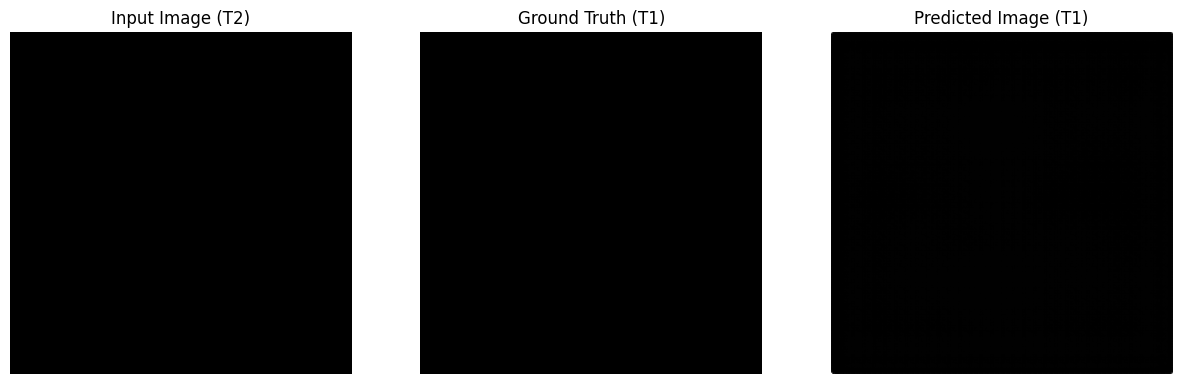

Epoch 6/100 | Step 300
--- Epoch 6 Evaluation ---
PSNR: 33.28
SSIM: 0.9351
----------------------------------------
Epoch 7/100 | Step 300
--- Epoch 7 Evaluation ---
PSNR: 33.93
SSIM: 0.9364
----------------------------------------
Epoch 8/100 | Step 300
--- Epoch 8 Evaluation ---
PSNR: 33.38
SSIM: 0.9453
----------------------------------------
Epoch 9/100 | Step 300
--- Epoch 9 Evaluation ---
PSNR: 34.00
SSIM: 0.9462
----------------------------------------
Epoch 10/100 | Step 300
--- Epoch 10 Evaluation ---
PSNR: 32.03
SSIM: 0.9370
----------------------------------------


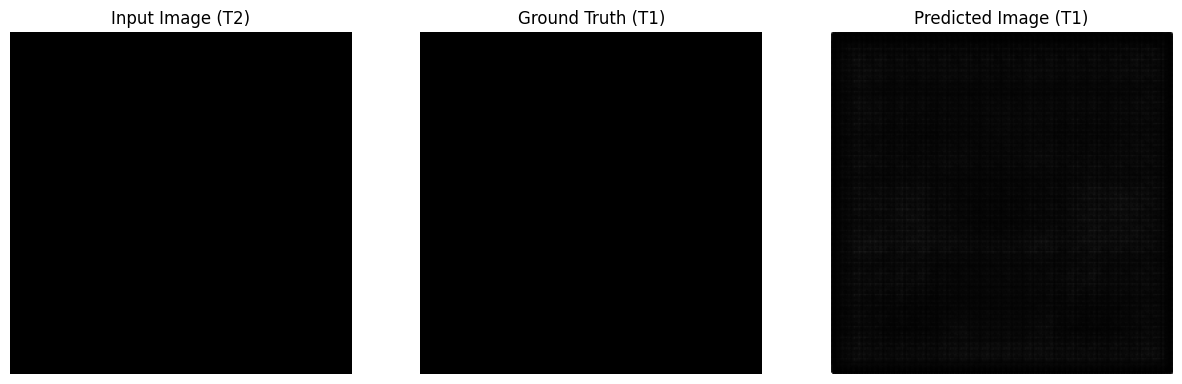

Epoch 11/100 | Step 300
--- Epoch 11 Evaluation ---
PSNR: 34.43
SSIM: 0.9464
----------------------------------------
Epoch 12/100 | Step 300
--- Epoch 12 Evaluation ---
PSNR: 34.61
SSIM: 0.9482
----------------------------------------
Epoch 13/100 | Step 300
--- Epoch 13 Evaluation ---
PSNR: 35.27
SSIM: 0.9479
----------------------------------------
Epoch 14/100 | Step 300
--- Epoch 14 Evaluation ---
PSNR: 34.79
SSIM: 0.9445
----------------------------------------
Epoch 15/100 | Step 300
--- Epoch 15 Evaluation ---
PSNR: 36.49
SSIM: 0.9415
----------------------------------------


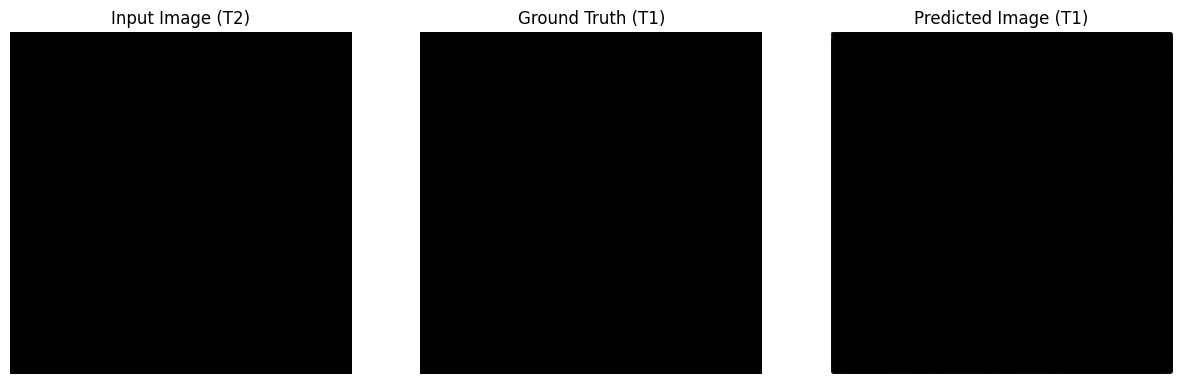

Epoch 16/100 | Step 300
--- Epoch 16 Evaluation ---
PSNR: 36.51
SSIM: 0.9428
----------------------------------------
Epoch 17/100 | Step 300
--- Epoch 17 Evaluation ---
PSNR: 33.58
SSIM: 0.9439
----------------------------------------
Epoch 18/100 | Step 300
--- Epoch 18 Evaluation ---
PSNR: 31.77
SSIM: 0.9366
----------------------------------------
Epoch 19/100 | Step 300
--- Epoch 19 Evaluation ---
PSNR: 32.36
SSIM: 0.9350
----------------------------------------
Epoch 20/100 | Step 300
--- Epoch 20 Evaluation ---
PSNR: 35.96
SSIM: 0.9472
----------------------------------------


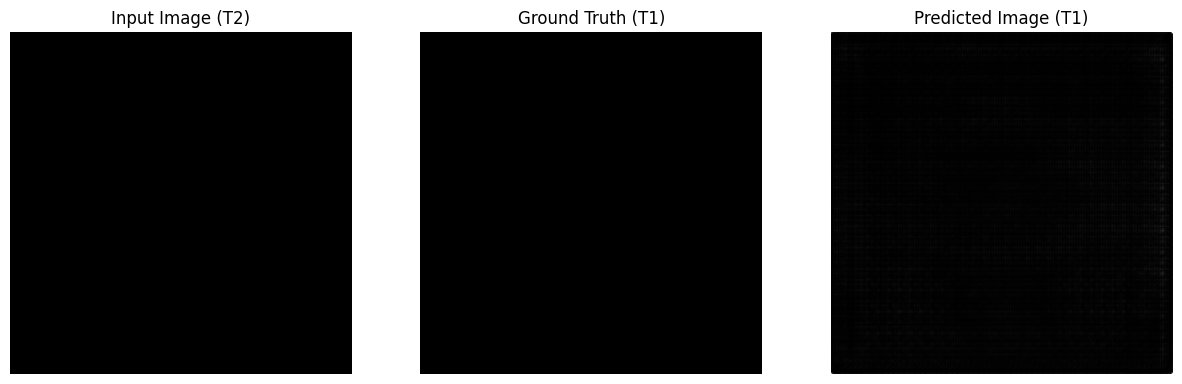

Epoch 21/100 | Step 300
--- Epoch 21 Evaluation ---
PSNR: 37.98
SSIM: 0.9390
----------------------------------------
Epoch 22/100 | Step 300
--- Epoch 22 Evaluation ---
PSNR: 34.48
SSIM: 0.9424
----------------------------------------
Epoch 23/100 | Step 300
--- Epoch 23 Evaluation ---
PSNR: 34.24
SSIM: 0.9445
----------------------------------------
Epoch 24/100 | Step 300
--- Epoch 24 Evaluation ---
PSNR: 38.00
SSIM: 0.9523
----------------------------------------
Epoch 25/100 | Step 300
--- Epoch 25 Evaluation ---
PSNR: 37.57
SSIM: 0.9455
----------------------------------------


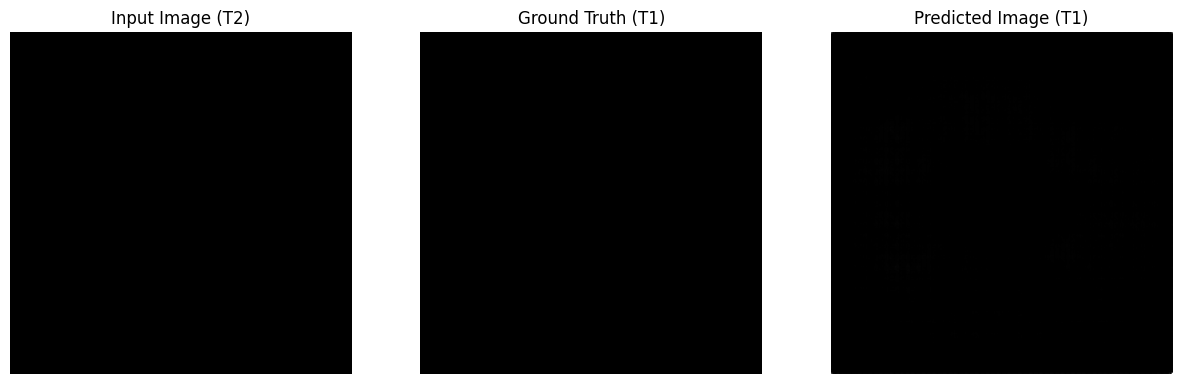

Epoch 26/100 | Step 300
--- Epoch 26 Evaluation ---
PSNR: 27.56
SSIM: 0.4637
----------------------------------------
Epoch 27/100 | Step 300
--- Epoch 27 Evaluation ---
PSNR: 37.82
SSIM: 0.9474
----------------------------------------
Epoch 28/100 | Step 300
--- Epoch 28 Evaluation ---
PSNR: 31.82
SSIM: 0.9373
----------------------------------------
Epoch 29/100 | Step 300
--- Epoch 29 Evaluation ---
PSNR: 36.81
SSIM: 0.9496
----------------------------------------
Epoch 30/100 | Step 300
--- Epoch 30 Evaluation ---
PSNR: 36.46
SSIM: 0.9465
----------------------------------------


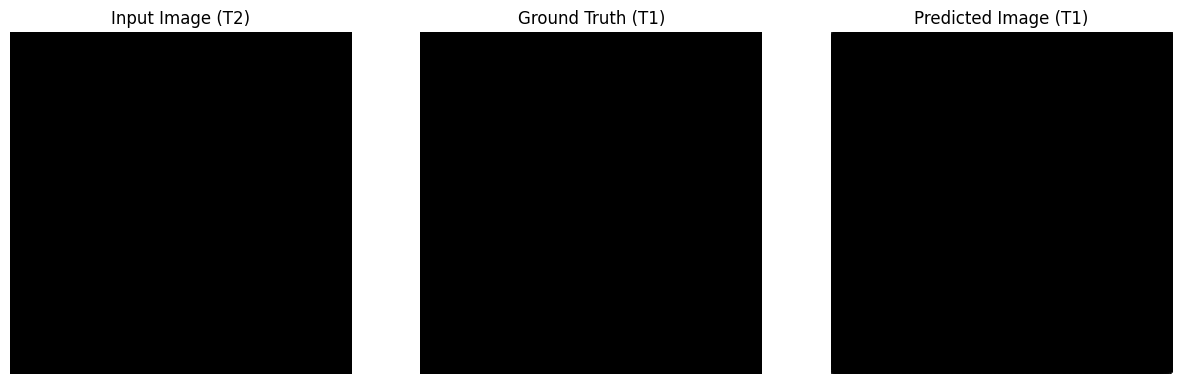

Epoch 31/100 | Step 300
--- Epoch 31 Evaluation ---
PSNR: 37.48
SSIM: 0.9437
----------------------------------------
Epoch 32/100 | Step 300
--- Epoch 32 Evaluation ---
PSNR: 30.52
SSIM: 0.8984
----------------------------------------
Epoch 33/100 | Step 300
--- Epoch 33 Evaluation ---
PSNR: 37.94
SSIM: 0.9458
----------------------------------------
Epoch 34/100 | Step 300
--- Epoch 34 Evaluation ---
PSNR: 36.73
SSIM: 0.9461
----------------------------------------
Epoch 35/100 | Step 300
--- Epoch 35 Evaluation ---
PSNR: 35.77
SSIM: 0.9459
----------------------------------------


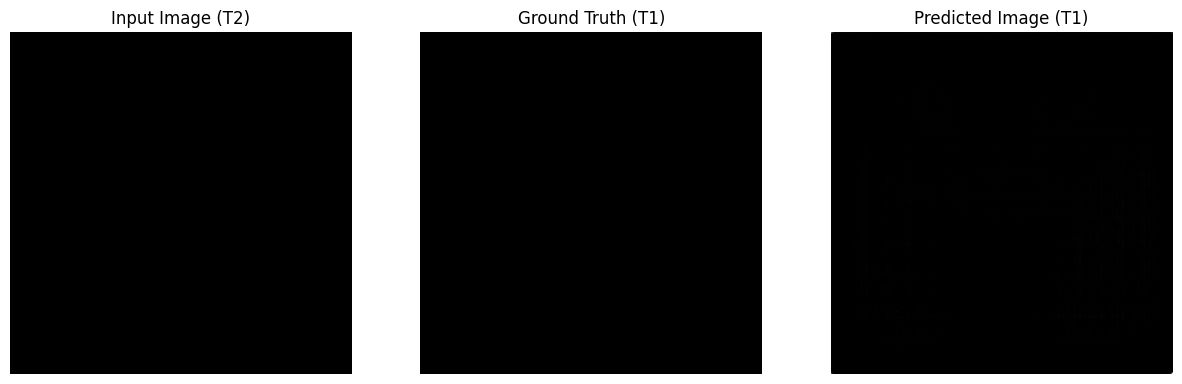

Epoch 36/100 | Step 300
--- Epoch 36 Evaluation ---
PSNR: 35.40
SSIM: 0.9452
----------------------------------------
Epoch 37/100 | Step 300
--- Epoch 37 Evaluation ---
PSNR: 35.93
SSIM: 0.9458
----------------------------------------
Epoch 38/100 | Step 300
--- Epoch 38 Evaluation ---
PSNR: 36.07
SSIM: 0.9427
----------------------------------------
Epoch 39/100 | Step 300
--- Epoch 39 Evaluation ---
PSNR: 30.75
SSIM: 0.9158
----------------------------------------
Epoch 40/100 | Step 300
--- Epoch 40 Evaluation ---
PSNR: 36.05
SSIM: 0.9383
----------------------------------------


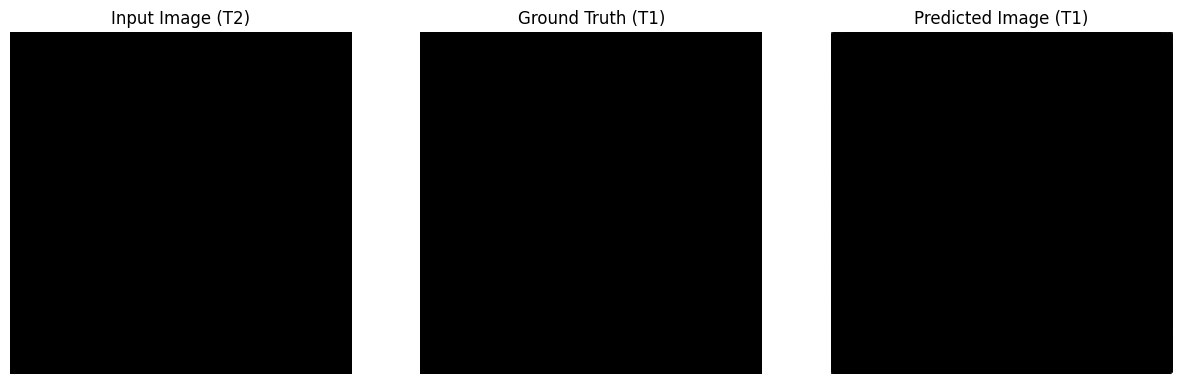

Epoch 41/100 | Step 300
--- Epoch 41 Evaluation ---
PSNR: 35.71
SSIM: 0.9429
----------------------------------------
Epoch 42/100 | Step 300
--- Epoch 42 Evaluation ---
PSNR: 36.17
SSIM: 0.9465
----------------------------------------
Epoch 43/100 | Step 300
--- Epoch 43 Evaluation ---
PSNR: 36.22
SSIM: 0.9440
----------------------------------------
Epoch 44/100 | Step 300
--- Epoch 44 Evaluation ---
PSNR: 36.37
SSIM: 0.9417
----------------------------------------
Epoch 45/100 | Step 300
--- Epoch 45 Evaluation ---
PSNR: 33.35
SSIM: 0.9417
----------------------------------------


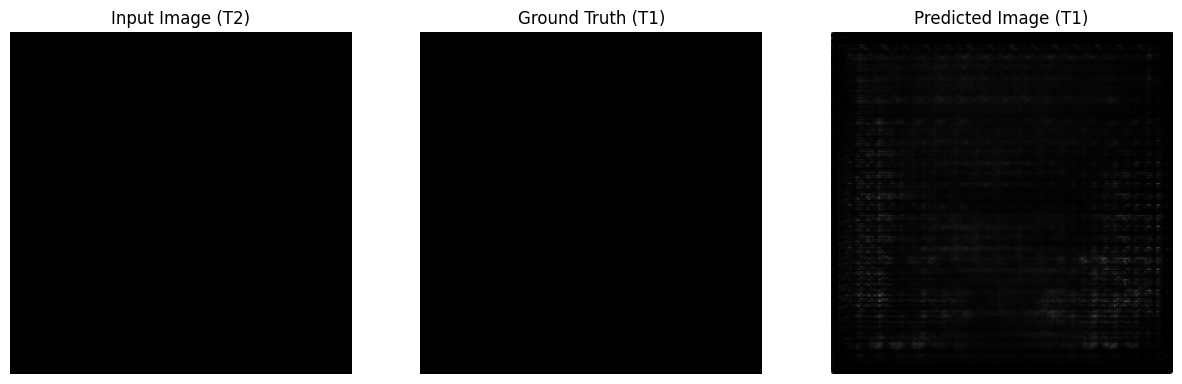

Epoch 46/100 | Step 300
--- Epoch 46 Evaluation ---
PSNR: 36.44
SSIM: 0.9452
----------------------------------------
Epoch 47/100 | Step 300
--- Epoch 47 Evaluation ---
PSNR: 30.62
SSIM: 0.9261
----------------------------------------
Epoch 48/100 | Step 300
--- Epoch 48 Evaluation ---
PSNR: 36.69
SSIM: 0.9432
----------------------------------------
Epoch 49/100 | Step 300
--- Epoch 49 Evaluation ---
PSNR: 36.08
SSIM: 0.9427
----------------------------------------
Epoch 50/100 | Step 300
--- Epoch 50 Evaluation ---
PSNR: 36.00
SSIM: 0.9418
----------------------------------------


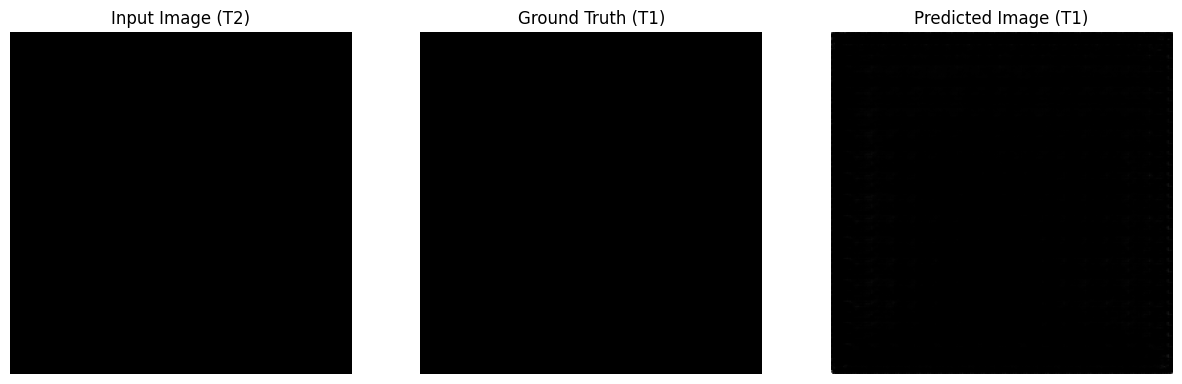

Epoch 51/100 | Step 300
--- Epoch 51 Evaluation ---
PSNR: 37.52
SSIM: 0.9429
----------------------------------------
Epoch 52/100 | Step 300
--- Epoch 52 Evaluation ---
PSNR: 35.69
SSIM: 0.9445
----------------------------------------
Epoch 53/100 | Step 300
--- Epoch 53 Evaluation ---
PSNR: 36.67
SSIM: 0.9442
----------------------------------------
Epoch 54/100 | Step 300
--- Epoch 54 Evaluation ---
PSNR: 36.85
SSIM: 0.9424
----------------------------------------
Epoch 55/100 | Step 300
--- Epoch 55 Evaluation ---
PSNR: 37.86
SSIM: 0.9429
----------------------------------------


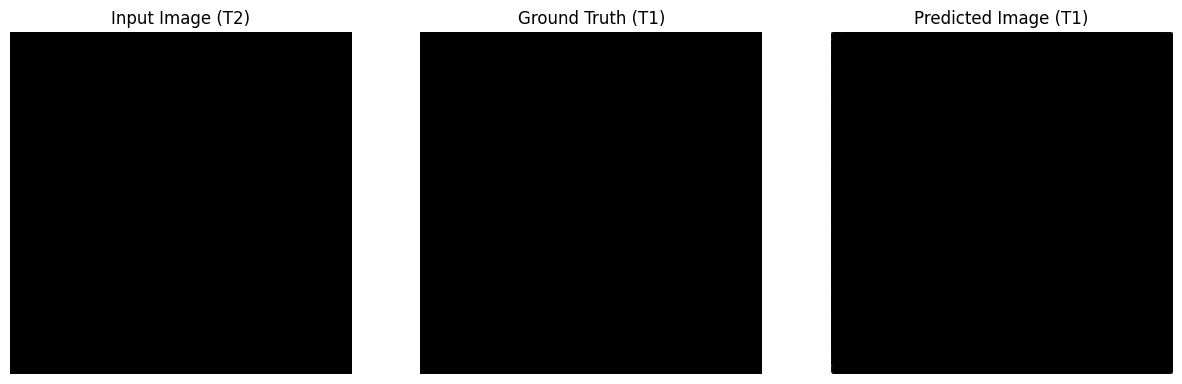

Epoch 56/100 | Step 300
--- Epoch 56 Evaluation ---
PSNR: 37.38
SSIM: 0.9441
----------------------------------------
Epoch 57/100 | Step 300
--- Epoch 57 Evaluation ---
PSNR: 37.25
SSIM: 0.9453
----------------------------------------
Epoch 58/100 | Step 300
--- Epoch 58 Evaluation ---
PSNR: 28.92
SSIM: 0.8703
----------------------------------------
Epoch 59/100 | Step 300
--- Epoch 59 Evaluation ---
PSNR: 35.04
SSIM: 0.9439
----------------------------------------
Epoch 60/100 | Step 300
--- Epoch 60 Evaluation ---
PSNR: 36.79
SSIM: 0.9473
----------------------------------------


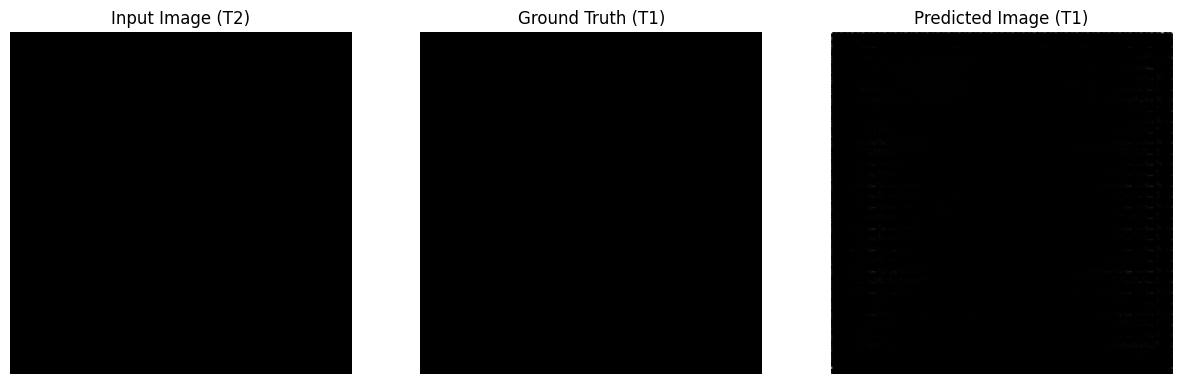

Epoch 61/100 | Step 300
--- Epoch 61 Evaluation ---
PSNR: 38.81
SSIM: 0.9457
----------------------------------------
Epoch 62/100 | Step 300
--- Epoch 62 Evaluation ---
PSNR: 38.47
SSIM: 0.9447
----------------------------------------
Epoch 63/100 | Step 300
--- Epoch 63 Evaluation ---
PSNR: 39.18
SSIM: 0.9434
----------------------------------------
Epoch 64/100 | Step 300
--- Epoch 64 Evaluation ---
PSNR: 18.34
SSIM: 0.2272
----------------------------------------
Epoch 65/100 | Step 300
--- Epoch 65 Evaluation ---
PSNR: 35.81
SSIM: 0.9445
----------------------------------------


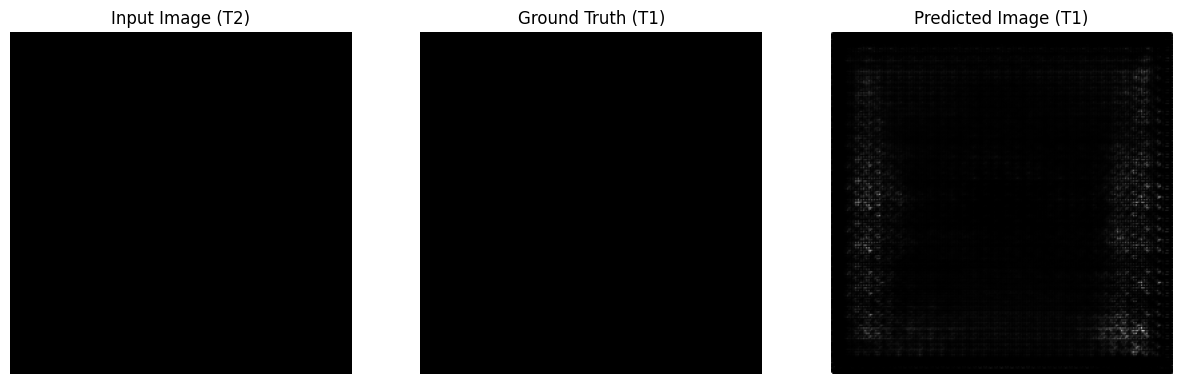

Epoch 66/100 | Step 300
--- Epoch 66 Evaluation ---
PSNR: 38.29
SSIM: 0.9459
----------------------------------------
Epoch 67/100 | Step 300
--- Epoch 67 Evaluation ---
PSNR: 38.05
SSIM: 0.9469
----------------------------------------
Epoch 68/100 | Step 300
--- Epoch 68 Evaluation ---
PSNR: 31.75
SSIM: 0.9412
----------------------------------------
Epoch 69/100 | Step 300
--- Epoch 69 Evaluation ---
PSNR: 29.55
SSIM: 0.9332
----------------------------------------
Epoch 70/100 | Step 300
--- Epoch 70 Evaluation ---
PSNR: 31.09
SSIM: 0.9378
----------------------------------------


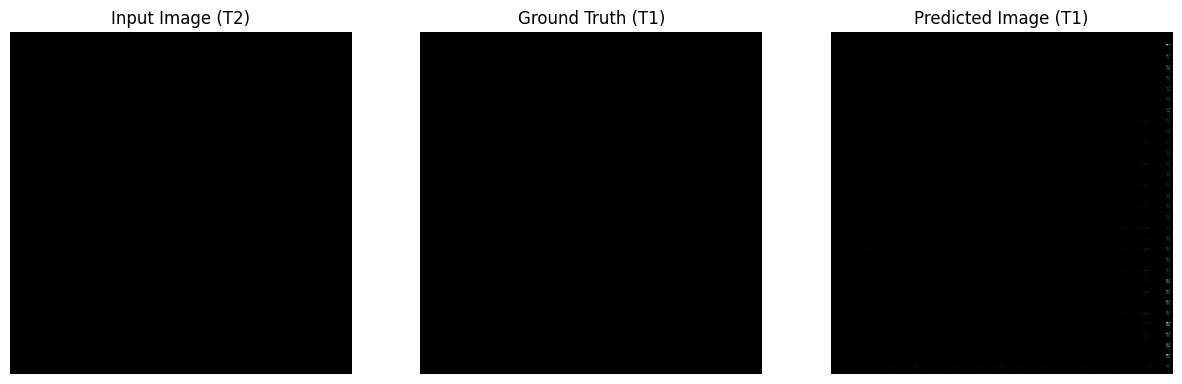

Epoch 71/100 | Step 300
--- Epoch 71 Evaluation ---
PSNR: 37.92
SSIM: 0.9450
----------------------------------------
Epoch 72/100 | Step 300
--- Epoch 72 Evaluation ---
PSNR: 34.94
SSIM: 0.9474
----------------------------------------
Epoch 73/100 | Step 300
--- Epoch 73 Evaluation ---
PSNR: 38.77
SSIM: 0.9455
----------------------------------------
Epoch 74/100 | Step 300
--- Epoch 74 Evaluation ---
PSNR: 39.36
SSIM: 0.9459
----------------------------------------
Epoch 75/100 | Step 300
--- Epoch 75 Evaluation ---
PSNR: 38.00
SSIM: 0.9459
----------------------------------------


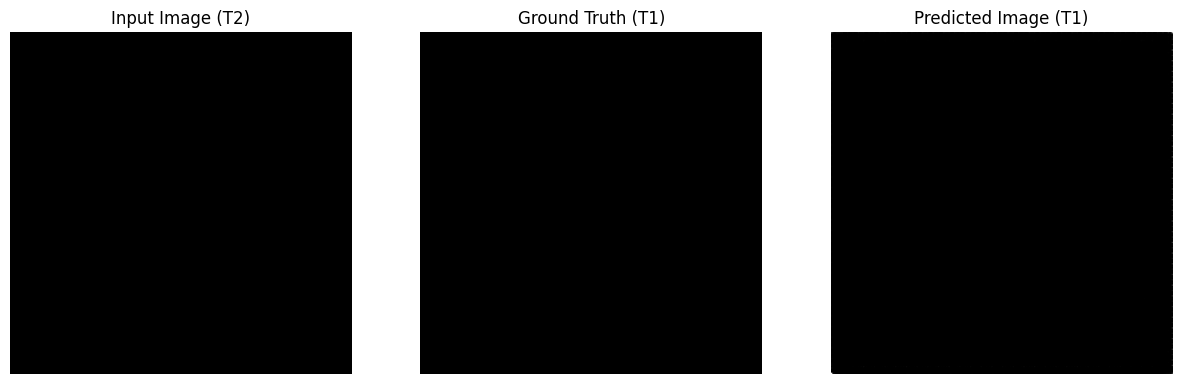

Epoch 76/100 | Step 300
--- Epoch 76 Evaluation ---
PSNR: 35.49
SSIM: 0.9411
----------------------------------------
Epoch 77/100 | Step 300
--- Epoch 77 Evaluation ---
PSNR: 28.84
SSIM: 0.8420
----------------------------------------
Epoch 78/100 | Step 300
--- Epoch 78 Evaluation ---
PSNR: 28.34
SSIM: 0.8279
----------------------------------------
Epoch 79/100 | Step 300
--- Epoch 79 Evaluation ---
PSNR: 29.57
SSIM: 0.9062
----------------------------------------
Epoch 80/100 | Step 300
--- Epoch 80 Evaluation ---
PSNR: 37.65
SSIM: 0.9468
----------------------------------------


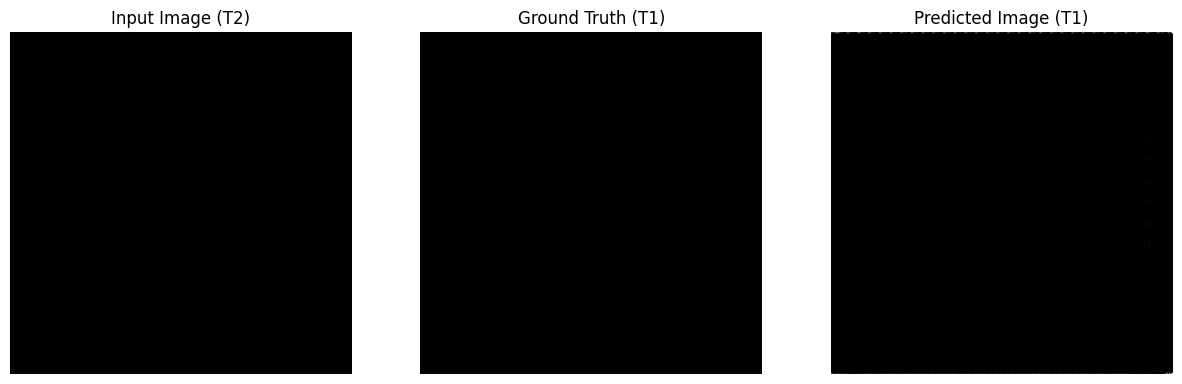

Epoch 81/100 | Step 300
--- Epoch 81 Evaluation ---
PSNR: 36.52
SSIM: 0.9438
----------------------------------------
Epoch 82/100 | Step 300
--- Epoch 82 Evaluation ---
PSNR: 37.51
SSIM: 0.9458
----------------------------------------
Epoch 83/100 | Step 300
--- Epoch 83 Evaluation ---
PSNR: 36.91
SSIM: 0.9465
----------------------------------------
Epoch 84/100 | Step 300
--- Epoch 84 Evaluation ---
PSNR: 37.20
SSIM: 0.9436
----------------------------------------
Epoch 85/100 | Step 300
--- Epoch 85 Evaluation ---
PSNR: 37.78
SSIM: 0.9460
----------------------------------------


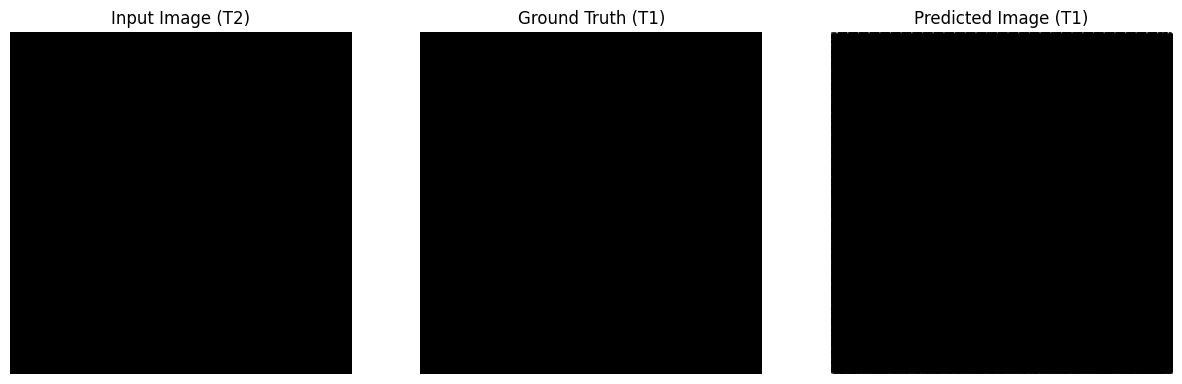

Epoch 86/100 | Step 300
--- Epoch 86 Evaluation ---
PSNR: 38.38
SSIM: 0.9457
----------------------------------------
Epoch 87/100 | Step 300
--- Epoch 87 Evaluation ---
PSNR: 37.21
SSIM: 0.9478
----------------------------------------
Epoch 88/100 | Step 300
--- Epoch 88 Evaluation ---
PSNR: 36.36
SSIM: 0.9455
----------------------------------------
Epoch 89/100 | Step 300
--- Epoch 89 Evaluation ---
PSNR: 38.98
SSIM: 0.9468
----------------------------------------
Epoch 90/100 | Step 300
--- Epoch 90 Evaluation ---
PSNR: 39.30
SSIM: 0.9476
----------------------------------------


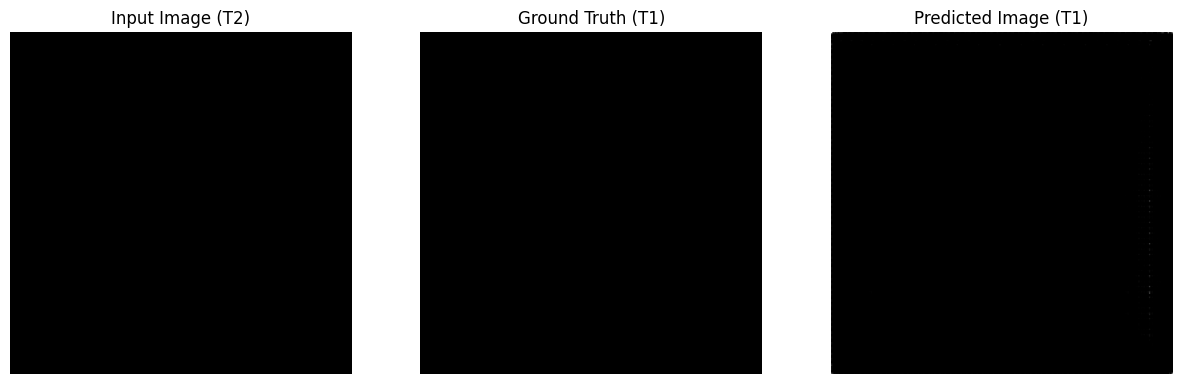

Epoch 91/100 | Step 300
--- Epoch 91 Evaluation ---
PSNR: 38.37
SSIM: 0.9465
----------------------------------------
Epoch 92/100 | Step 300
--- Epoch 92 Evaluation ---
PSNR: 38.33
SSIM: 0.9442
----------------------------------------
Epoch 93/100 | Step 300
--- Epoch 93 Evaluation ---
PSNR: 33.70
SSIM: 0.9463
----------------------------------------
Epoch 94/100 | Step 300
--- Epoch 94 Evaluation ---
PSNR: 38.40
SSIM: 0.9459
----------------------------------------
Epoch 95/100 | Step 300
--- Epoch 95 Evaluation ---
PSNR: 37.23
SSIM: 0.9426
----------------------------------------


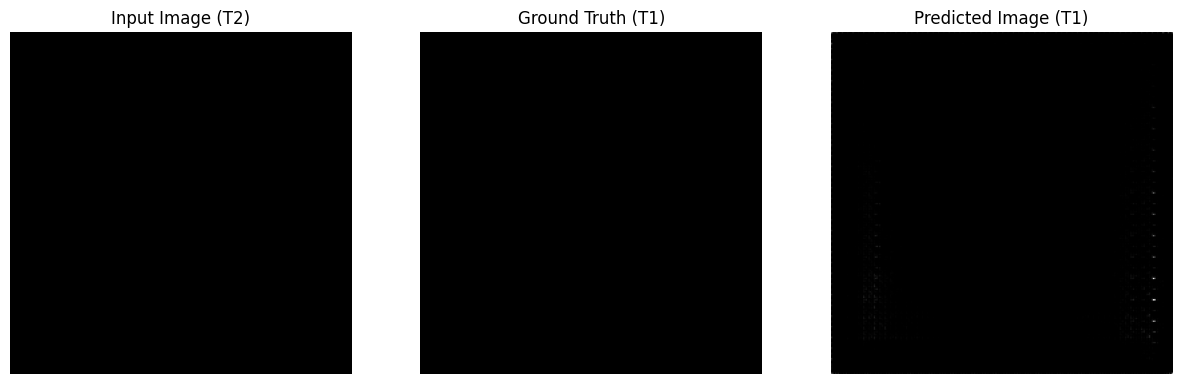

Epoch 96/100 | Step 300
--- Epoch 96 Evaluation ---
PSNR: 38.05
SSIM: 0.9471
----------------------------------------
Epoch 97/100 | Step 300
--- Epoch 97 Evaluation ---
PSNR: 27.95
SSIM: 0.8740
----------------------------------------
Epoch 98/100 | Step 300
--- Epoch 98 Evaluation ---
PSNR: 38.67
SSIM: 0.9465
----------------------------------------
Epoch 99/100 | Step 300
--- Epoch 99 Evaluation ---
PSNR: 38.33
SSIM: 0.9470
----------------------------------------
Epoch 100/100 | Step 300
--- Epoch 100 Evaluation ---
PSNR: 38.63
SSIM: 0.9478
----------------------------------------


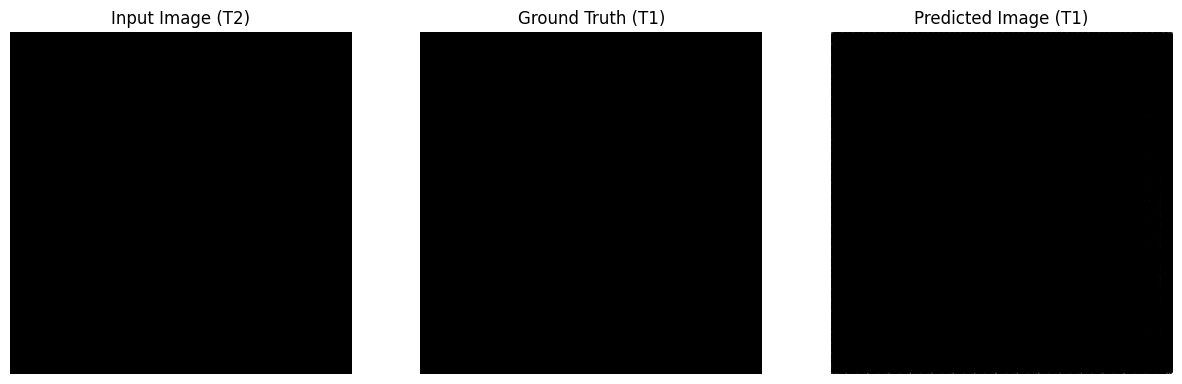


--- Final Summary for T1 -> T2 ---
Average PSNR: 38.63
Average SSIM: 0.9478


In [74]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# --- Prepare T1 -> T2 Data ---
train_ds_t1_t2, test_ds_t1_t2 = create_dataset(BRAIN_DATA_DIR, task='t1_to_t2', max_patients=PATIENT_LIMIT)

train_dataset_1 = train_ds_t1_t2.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset_1 = test_ds_t1_t2.map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE)

# --- Define Models ---
generator_t1_t2 = Generator()
discriminator_t1_t2 = Discriminator()

# --- Train T1 -> T2 ---
psnr_history_1, ssim_history_1 = fit_with_visualization(
    train_dataset_1,
    test_dataset_1,
    EPOCHS,
    generator_t1_t2,
    discriminator_t1_t2
)

# --- Evaluate T1 -> T2 ---
final_psnr_1, final_ssim_1 = calculate_metrics(test_dataset_1, generator_t1_t2)

print("\n--- Final Summary for T1 -> T2 ---")
print(f"Average PSNR: {final_psnr_1:.2f}")
print(f"Average SSIM: {final_ssim_1:.4f}")


--- Creating Comparison Grid ---


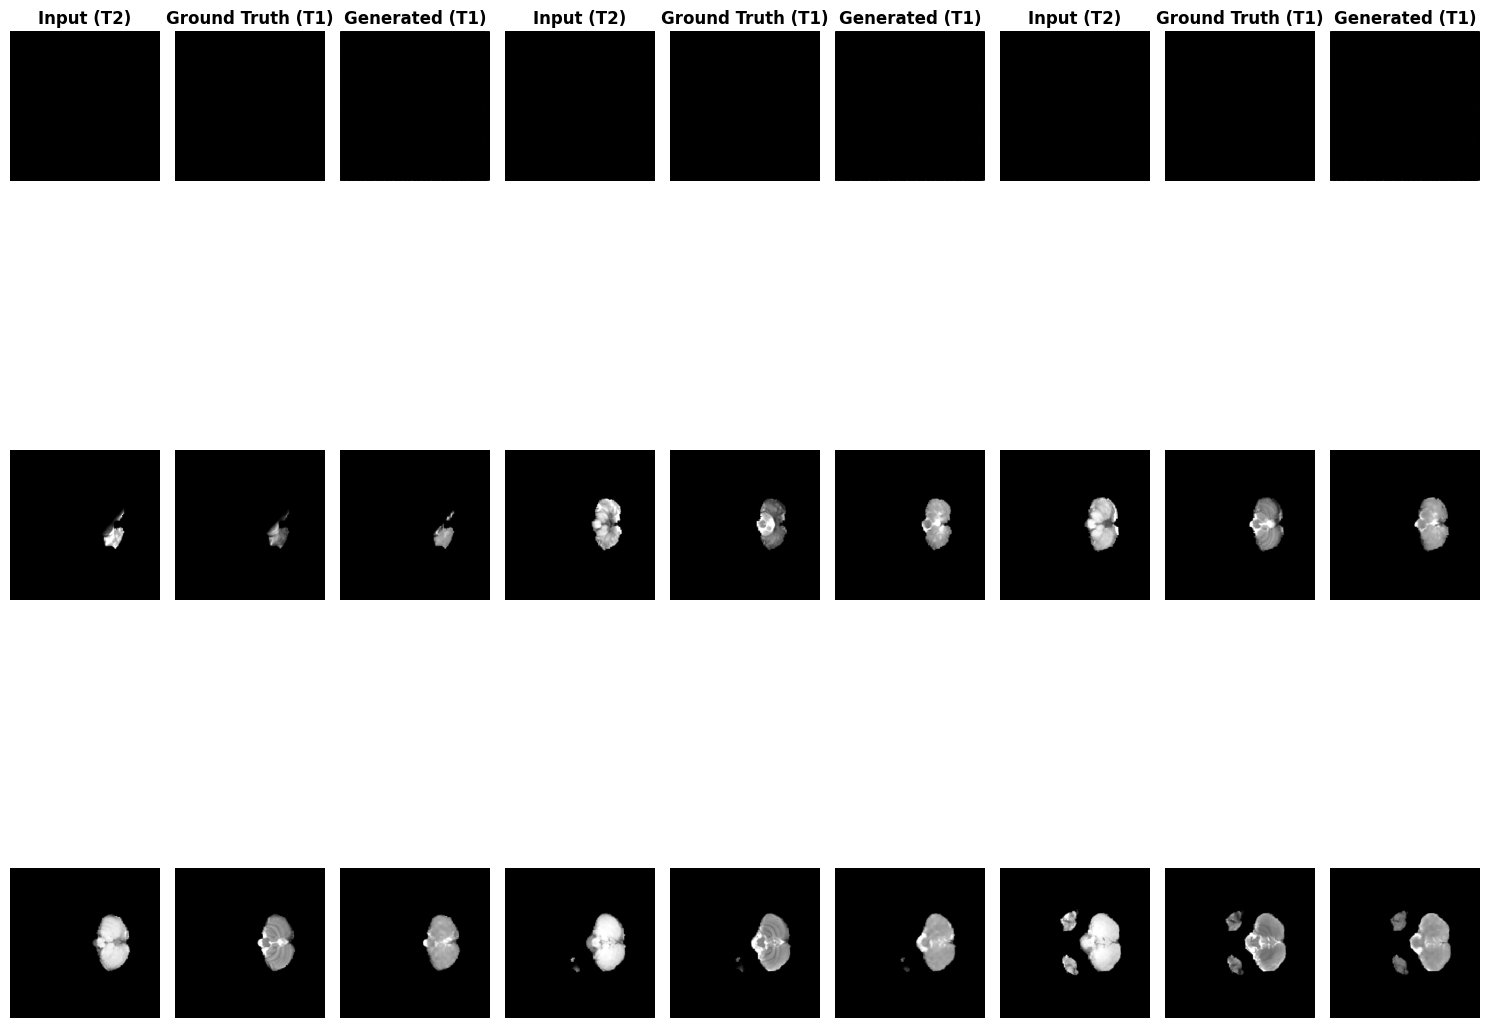

In [75]:
print("\n--- Creating Comparison Grid ---")
create_comparison_grid(test_dataset_1, generator_t1_t2, num_samples=9)


--- Quality Metrics Analysis ---
Calculating metrics for 20 test samples...


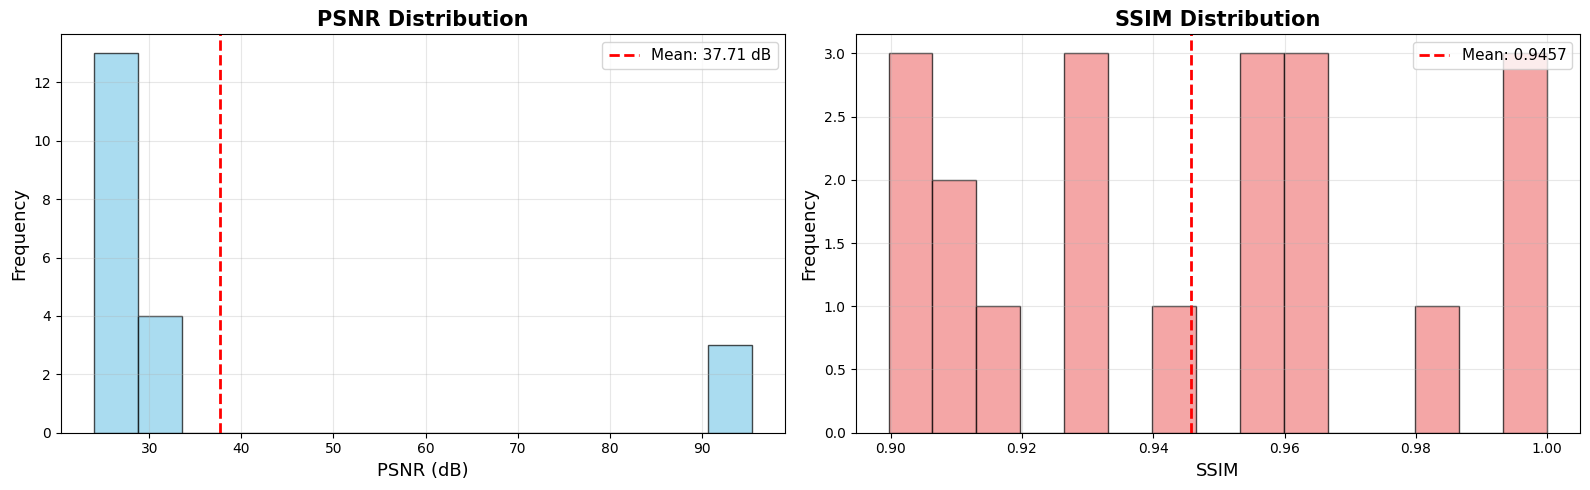


QUALITY METRICS STATISTICS
PSNR: Mean=37.71 dB, Std=24.33 dB
PSNR: Min=23.98 dB, Max=95.49 dB
SSIM: Mean=0.9457, Std=0.0335
SSIM: Min=0.8997, Max=1.0000



In [76]:
print("\n--- Quality Metrics Analysis ---")
visualize_quality_metrics(test_dataset_1, generator_t1_t2, num_samples=20)




--- Running Project 2: T2 -> T1 Synthesis ---

Processing 10 patients out of 10 potential pairs.
Total paired slices created for t2_to_t1: 1550
Starting training for 100 epochs...
Epoch 1/100 | Step 0

I0000 00:00:1766952200.268833      47 cuda_dnn.cc:529] Loaded cuDNN version 90300


Epoch 1/100 | Step 300
--- Epoch 1 Evaluation ---
PSNR: 27.32
SSIM: 0.8937
----------------------------------------
Epoch 2/100 | Step 300
--- Epoch 2 Evaluation ---
PSNR: 33.62
SSIM: 0.9465
----------------------------------------
Epoch 3/100 | Step 300
--- Epoch 3 Evaluation ---
PSNR: 29.94
SSIM: 0.9304
----------------------------------------
Epoch 4/100 | Step 300
--- Epoch 4 Evaluation ---
PSNR: 32.06
SSIM: 0.9412
----------------------------------------
Epoch 5/100 | Step 300
--- Epoch 5 Evaluation ---
PSNR: 26.43
SSIM: 0.2464
----------------------------------------


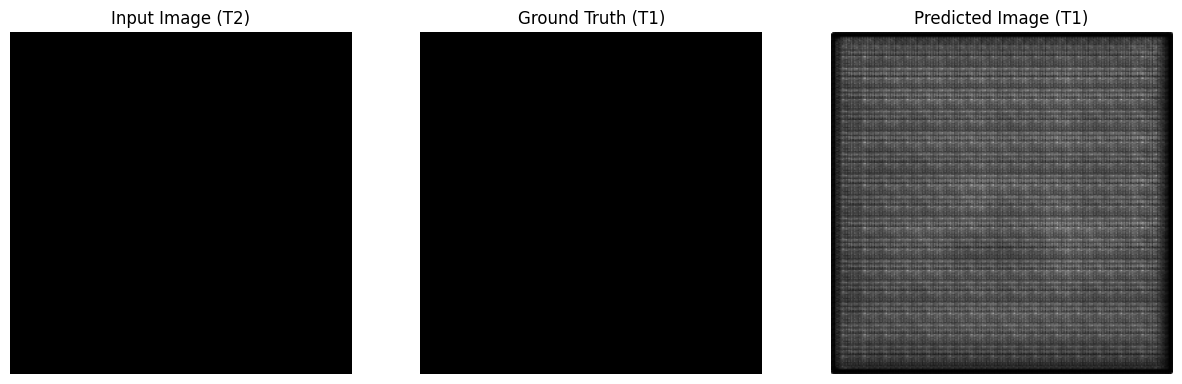

Epoch 6/100 | Step 300
--- Epoch 6 Evaluation ---
PSNR: 33.71
SSIM: 0.9459
----------------------------------------
Epoch 7/100 | Step 300
--- Epoch 7 Evaluation ---
PSNR: 28.03
SSIM: 0.6517
----------------------------------------
Epoch 8/100 | Step 300
--- Epoch 8 Evaluation ---
PSNR: 33.55
SSIM: 0.9421
----------------------------------------
Epoch 9/100 | Step 300
--- Epoch 9 Evaluation ---
PSNR: 26.81
SSIM: 0.3878
----------------------------------------
Epoch 10/100 | Step 300
--- Epoch 10 Evaluation ---
PSNR: 29.69
SSIM: 0.8632
----------------------------------------


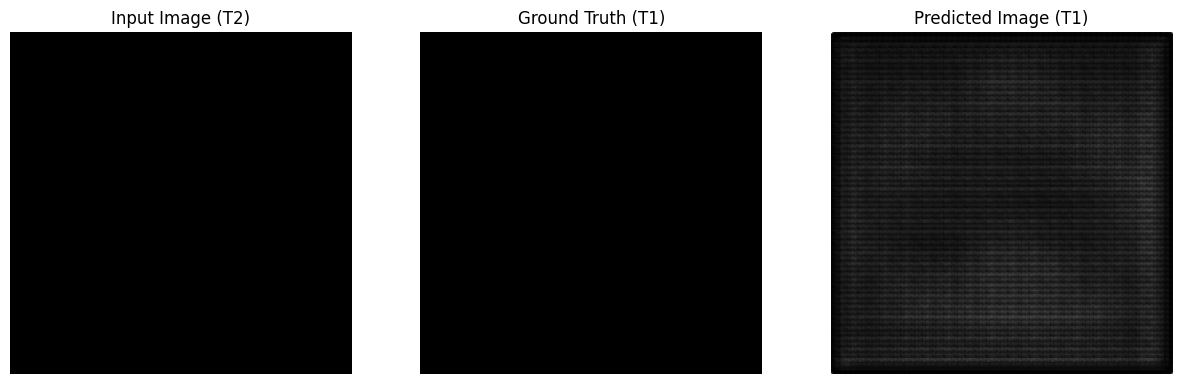

Epoch 11/100 | Step 300
--- Epoch 11 Evaluation ---
PSNR: 33.91
SSIM: 0.9429
----------------------------------------
Epoch 12/100 | Step 300
--- Epoch 12 Evaluation ---
PSNR: 33.36
SSIM: 0.9432
----------------------------------------
Epoch 13/100 | Step 300
--- Epoch 13 Evaluation ---
PSNR: 34.36
SSIM: 0.9461
----------------------------------------
Epoch 14/100 | Step 300
--- Epoch 14 Evaluation ---
PSNR: 34.37
SSIM: 0.9498
----------------------------------------
Epoch 15/100 | Step 300
--- Epoch 15 Evaluation ---
PSNR: 33.01
SSIM: 0.9359
----------------------------------------


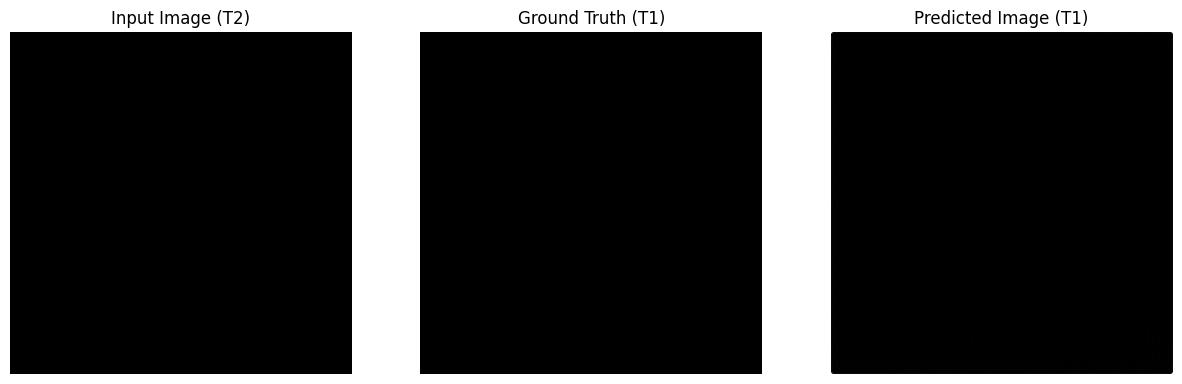

Epoch 16/100 | Step 300
--- Epoch 16 Evaluation ---
PSNR: 33.29
SSIM: 0.9472
----------------------------------------
Epoch 17/100 | Step 300
--- Epoch 17 Evaluation ---
PSNR: 35.88
SSIM: 0.9530
----------------------------------------
Epoch 18/100 | Step 300
--- Epoch 18 Evaluation ---
PSNR: 36.19
SSIM: 0.9441
----------------------------------------
Epoch 19/100 | Step 300
--- Epoch 19 Evaluation ---
PSNR: 35.19
SSIM: 0.9524
----------------------------------------
Epoch 20/100 | Step 300
--- Epoch 20 Evaluation ---
PSNR: 32.21
SSIM: 0.9464
----------------------------------------


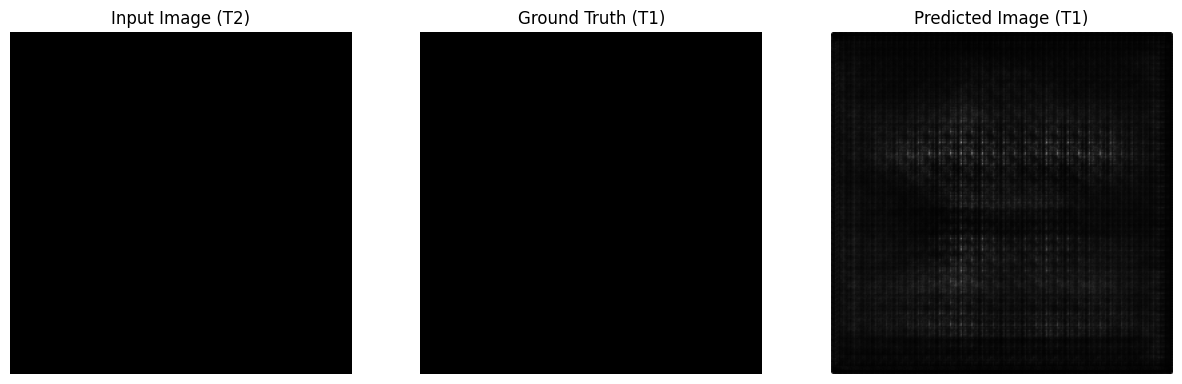

Epoch 21/100 | Step 300
--- Epoch 21 Evaluation ---
PSNR: 34.48
SSIM: 0.9499
----------------------------------------
Epoch 22/100 | Step 300
--- Epoch 22 Evaluation ---
PSNR: 28.87
SSIM: 0.8651
----------------------------------------
Epoch 23/100 | Step 300
--- Epoch 23 Evaluation ---
PSNR: 36.79
SSIM: 0.9461
----------------------------------------
Epoch 24/100 | Step 300
--- Epoch 24 Evaluation ---
PSNR: 35.08
SSIM: 0.9535
----------------------------------------
Epoch 25/100 | Step 300
--- Epoch 25 Evaluation ---
PSNR: 38.41
SSIM: 0.9537
----------------------------------------


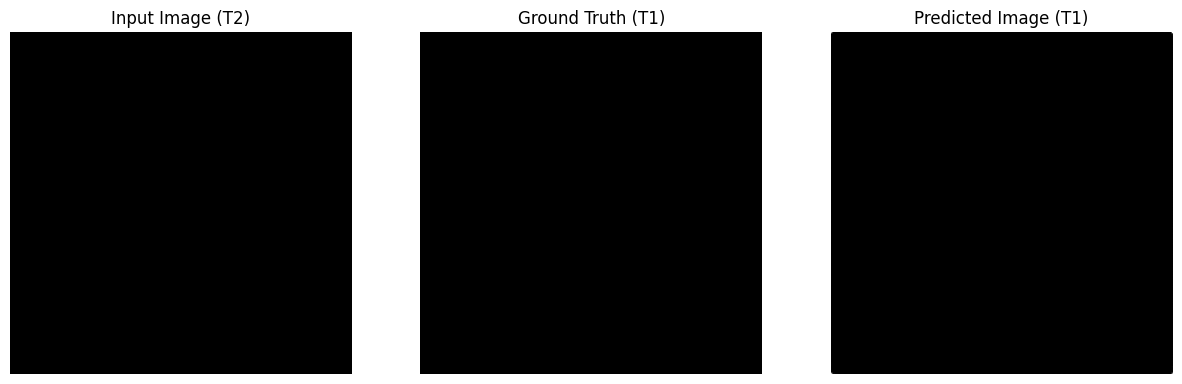

Epoch 26/100 | Step 300
--- Epoch 26 Evaluation ---
PSNR: 26.37
SSIM: 0.4188
----------------------------------------
Epoch 27/100 | Step 300
--- Epoch 27 Evaluation ---
PSNR: 35.94
SSIM: 0.9476
----------------------------------------
Epoch 28/100 | Step 300
--- Epoch 28 Evaluation ---
PSNR: 38.55
SSIM: 0.9566
----------------------------------------
Epoch 29/100 | Step 300
--- Epoch 29 Evaluation ---
PSNR: 16.55
SSIM: 0.1245
----------------------------------------
Epoch 30/100 | Step 300
--- Epoch 30 Evaluation ---
PSNR: 32.68
SSIM: 0.9510
----------------------------------------


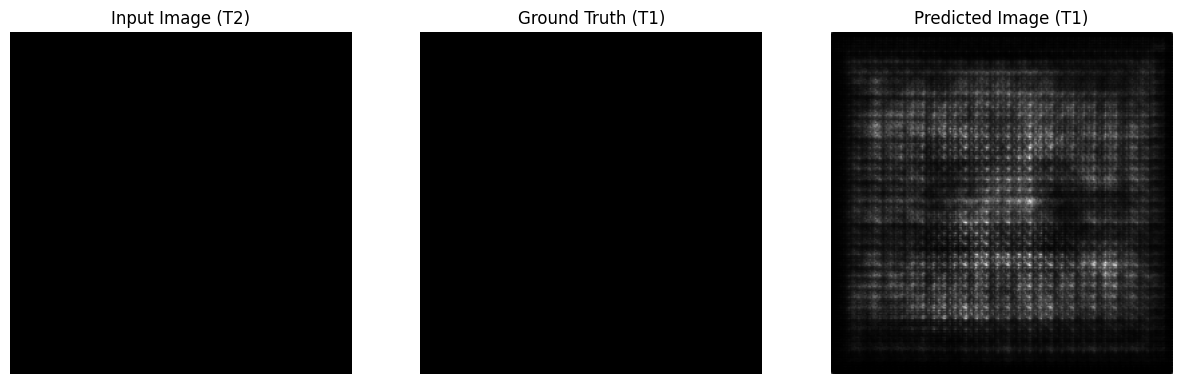

Epoch 31/100 | Step 300
--- Epoch 31 Evaluation ---
PSNR: 32.87
SSIM: 0.9464
----------------------------------------
Epoch 32/100 | Step 300
--- Epoch 32 Evaluation ---
PSNR: 40.12
SSIM: 0.9564
----------------------------------------
Epoch 33/100 | Step 300
--- Epoch 33 Evaluation ---
PSNR: 39.67
SSIM: 0.9564
----------------------------------------
Epoch 34/100 | Step 300
--- Epoch 34 Evaluation ---
PSNR: 38.66
SSIM: 0.9525
----------------------------------------
Epoch 35/100 | Step 300
--- Epoch 35 Evaluation ---
PSNR: 38.68
SSIM: 0.9570
----------------------------------------


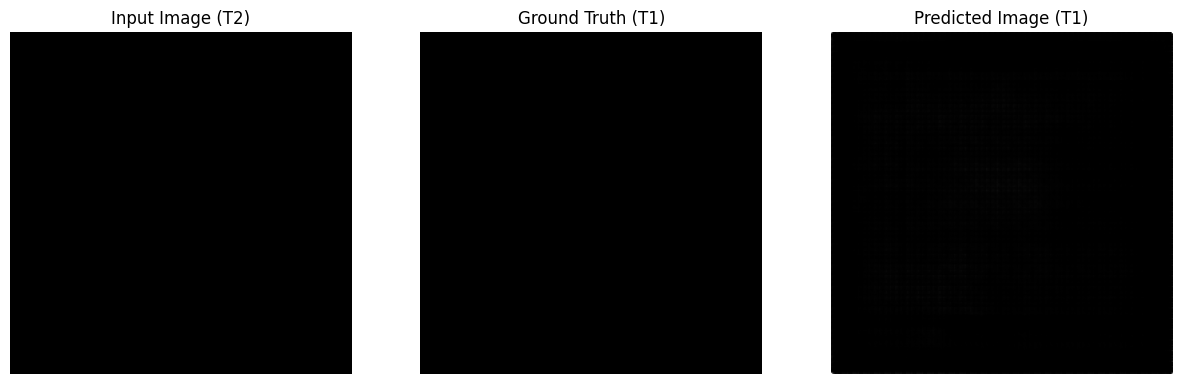

Epoch 36/100 | Step 300
--- Epoch 36 Evaluation ---
PSNR: 39.54
SSIM: 0.9552
----------------------------------------
Epoch 37/100 | Step 300
--- Epoch 37 Evaluation ---
PSNR: 39.97
SSIM: 0.9541
----------------------------------------
Epoch 38/100 | Step 300
--- Epoch 38 Evaluation ---
PSNR: 27.74
SSIM: 0.6814
----------------------------------------
Epoch 39/100 | Step 300
--- Epoch 39 Evaluation ---
PSNR: 32.85
SSIM: 0.9525
----------------------------------------
Epoch 40/100 | Step 300
--- Epoch 40 Evaluation ---
PSNR: 27.60
SSIM: 0.6467
----------------------------------------


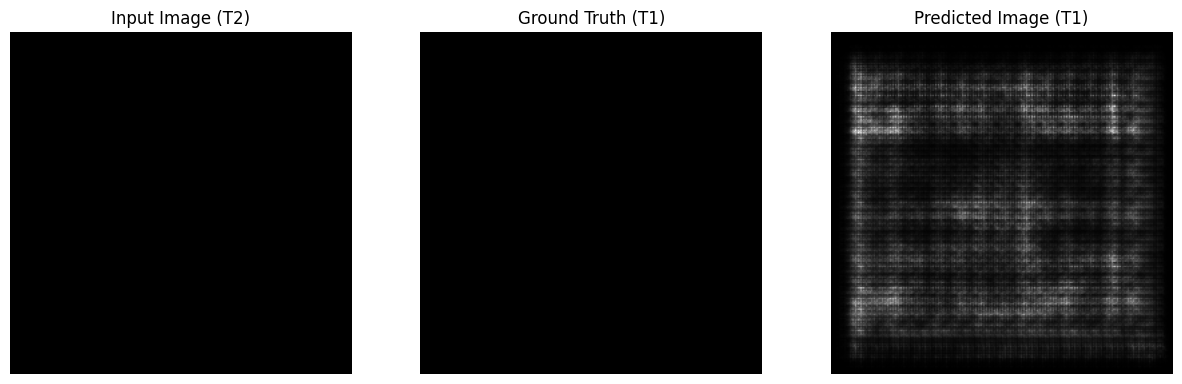

Epoch 41/100 | Step 300
--- Epoch 41 Evaluation ---
PSNR: 20.94
SSIM: 0.2364
----------------------------------------
Epoch 42/100 | Step 300
--- Epoch 42 Evaluation ---
PSNR: 39.39
SSIM: 0.9595
----------------------------------------
Epoch 43/100 | Step 300
--- Epoch 43 Evaluation ---
PSNR: 26.67
SSIM: 0.5589
----------------------------------------
Epoch 44/100 | Step 300
--- Epoch 44 Evaluation ---
PSNR: 27.83
SSIM: 0.6869
----------------------------------------
Epoch 45/100 | Step 300
--- Epoch 45 Evaluation ---
PSNR: 13.12
SSIM: 0.1386
----------------------------------------


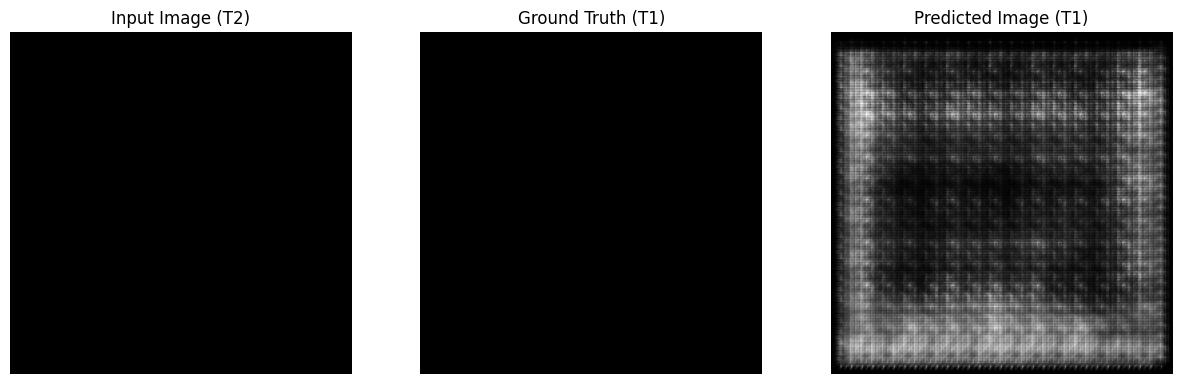

Epoch 46/100 | Step 300
--- Epoch 46 Evaluation ---
PSNR: 18.55
SSIM: 0.2195
----------------------------------------
Epoch 47/100 | Step 300
--- Epoch 47 Evaluation ---
PSNR: 38.21
SSIM: 0.9565
----------------------------------------
Epoch 48/100 | Step 300
--- Epoch 48 Evaluation ---
PSNR: 32.04
SSIM: 0.9379
----------------------------------------
Epoch 49/100 | Step 300
--- Epoch 49 Evaluation ---
PSNR: 16.35
SSIM: 0.1861
----------------------------------------
Epoch 50/100 | Step 300
--- Epoch 50 Evaluation ---
PSNR: 27.07
SSIM: 0.6236
----------------------------------------


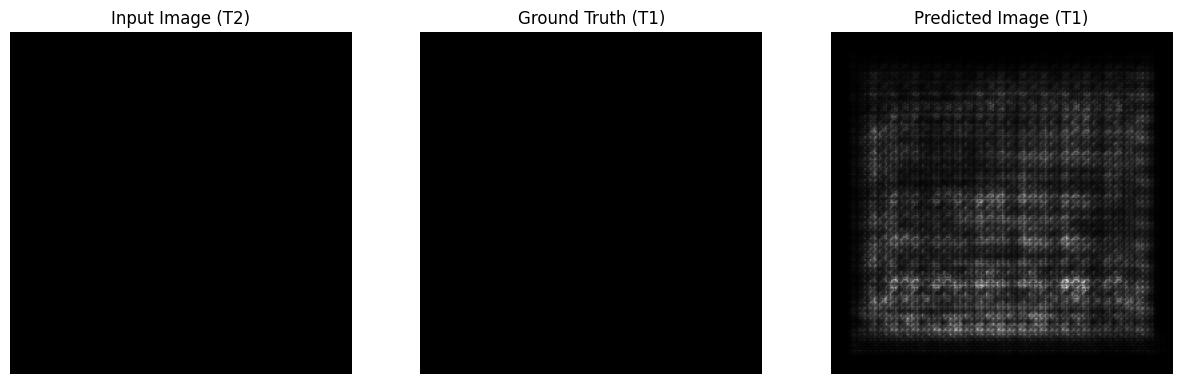

Epoch 51/100 | Step 300
--- Epoch 51 Evaluation ---
PSNR: 19.31
SSIM: 0.2348
----------------------------------------
Epoch 52/100 | Step 300
--- Epoch 52 Evaluation ---
PSNR: 38.78
SSIM: 0.9561
----------------------------------------
Epoch 53/100 | Step 300
--- Epoch 53 Evaluation ---
PSNR: 16.04
SSIM: 0.2840
----------------------------------------
Epoch 54/100 | Step 300
--- Epoch 54 Evaluation ---
PSNR: 38.08
SSIM: 0.9544
----------------------------------------
Epoch 55/100 | Step 300
--- Epoch 55 Evaluation ---
PSNR: 35.53
SSIM: 0.9554
----------------------------------------


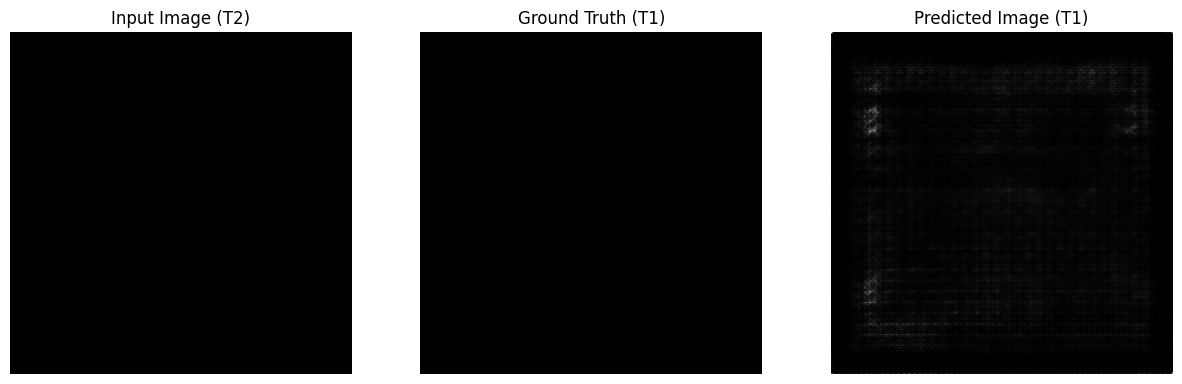

Epoch 56/100 | Step 300
--- Epoch 56 Evaluation ---
PSNR: 11.98
SSIM: 0.1612
----------------------------------------
Epoch 57/100 | Step 300
--- Epoch 57 Evaluation ---
PSNR: 39.09
SSIM: 0.9538
----------------------------------------
Epoch 58/100 | Step 300
--- Epoch 58 Evaluation ---
PSNR: 15.19
SSIM: 0.1941
----------------------------------------
Epoch 59/100 | Step 300
--- Epoch 59 Evaluation ---
PSNR: 37.08
SSIM: 0.9530
----------------------------------------
Epoch 60/100 | Step 300
--- Epoch 60 Evaluation ---
PSNR: 35.98
SSIM: 0.9539
----------------------------------------


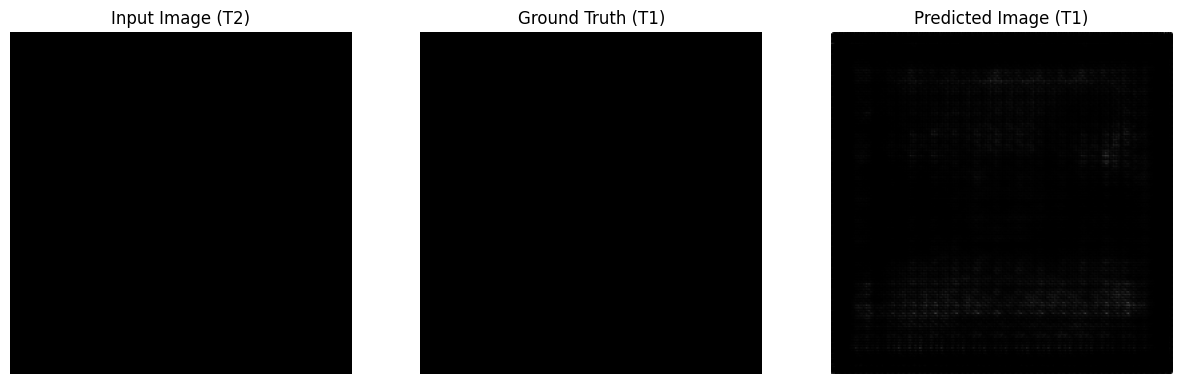

Epoch 61/100 | Step 300
--- Epoch 61 Evaluation ---
PSNR: 26.21
SSIM: 0.6724
----------------------------------------
Epoch 62/100 | Step 300
--- Epoch 62 Evaluation ---
PSNR: 37.00
SSIM: 0.9547
----------------------------------------
Epoch 63/100 | Step 300
--- Epoch 63 Evaluation ---
PSNR: 38.81
SSIM: 0.9548
----------------------------------------
Epoch 64/100 | Step 300
--- Epoch 64 Evaluation ---
PSNR: 36.97
SSIM: 0.9539
----------------------------------------
Epoch 65/100 | Step 300
--- Epoch 65 Evaluation ---
PSNR: 39.10
SSIM: 0.9551
----------------------------------------


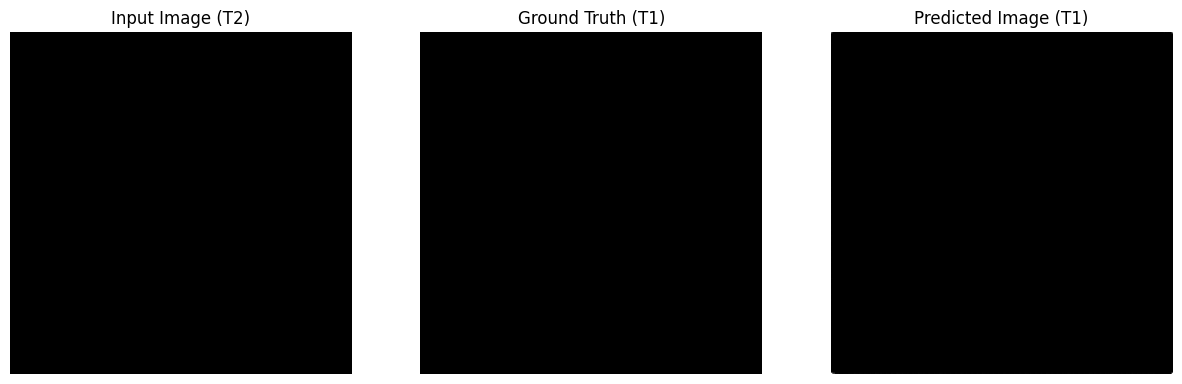

Epoch 66/100 | Step 300
--- Epoch 66 Evaluation ---
PSNR: 39.61
SSIM: 0.9573
----------------------------------------
Epoch 67/100 | Step 300
--- Epoch 67 Evaluation ---
PSNR: 38.50
SSIM: 0.9574
----------------------------------------
Epoch 68/100 | Step 300
--- Epoch 68 Evaluation ---
PSNR: 28.52
SSIM: 0.8357
----------------------------------------
Epoch 69/100 | Step 300
--- Epoch 69 Evaluation ---
PSNR: 38.65
SSIM: 0.9540
----------------------------------------
Epoch 70/100 | Step 300
--- Epoch 70 Evaluation ---
PSNR: 5.62
SSIM: 0.1320
----------------------------------------


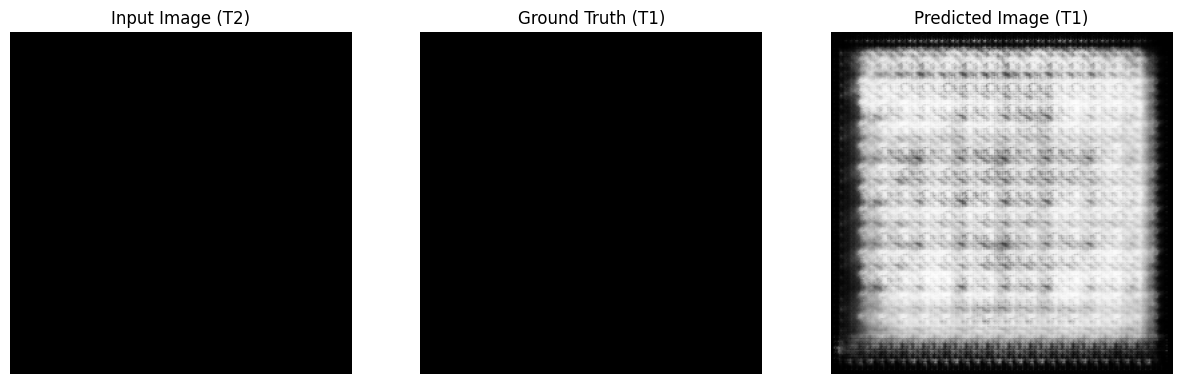

Epoch 71/100 | Step 300
--- Epoch 71 Evaluation ---
PSNR: 36.89
SSIM: 0.9558
----------------------------------------
Epoch 72/100 | Step 300
--- Epoch 72 Evaluation ---
PSNR: 8.84
SSIM: 0.2491
----------------------------------------
Epoch 73/100 | Step 300
--- Epoch 73 Evaluation ---
PSNR: 31.18
SSIM: 0.9202
----------------------------------------
Epoch 74/100 | Step 300
--- Epoch 74 Evaluation ---
PSNR: 40.41
SSIM: 0.9573
----------------------------------------
Epoch 75/100 | Step 300
--- Epoch 75 Evaluation ---
PSNR: 39.97
SSIM: 0.9553
----------------------------------------


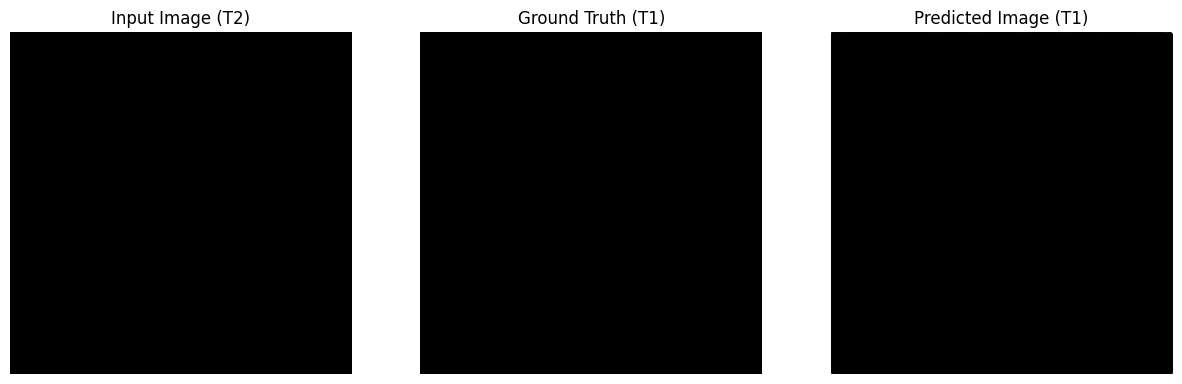

Epoch 76/100 | Step 300
--- Epoch 76 Evaluation ---
PSNR: 12.09
SSIM: 0.3517
----------------------------------------
Epoch 77/100 | Step 300
--- Epoch 77 Evaluation ---
PSNR: 10.10
SSIM: 0.3365
----------------------------------------
Epoch 78/100 | Step 300
--- Epoch 78 Evaluation ---
PSNR: 39.81
SSIM: 0.9579
----------------------------------------
Epoch 79/100 | Step 300
--- Epoch 79 Evaluation ---
PSNR: 5.42
SSIM: 0.1073
----------------------------------------
Epoch 80/100 | Step 300
--- Epoch 80 Evaluation ---
PSNR: 39.85
SSIM: 0.9577
----------------------------------------


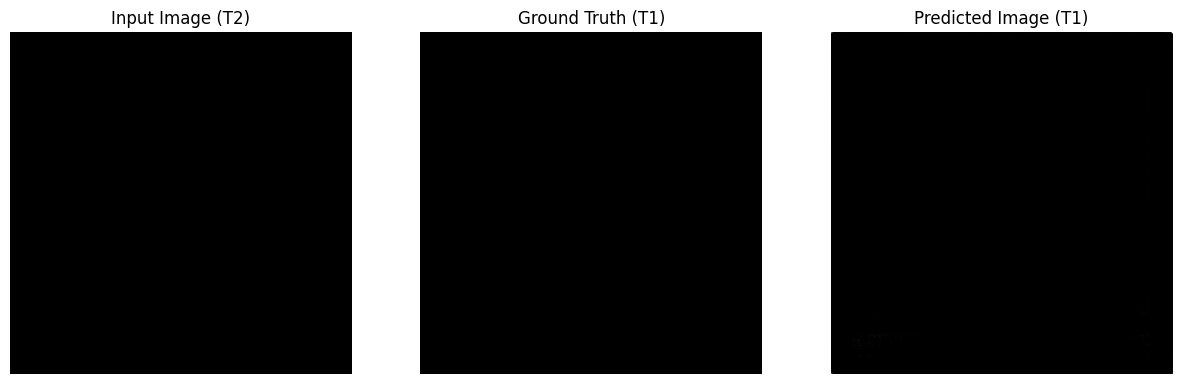

Epoch 81/100 | Step 300
--- Epoch 81 Evaluation ---
PSNR: 40.85
SSIM: 0.9559
----------------------------------------
Epoch 82/100 | Step 300
--- Epoch 82 Evaluation ---
PSNR: 5.84
SSIM: 0.1274
----------------------------------------
Epoch 83/100 | Step 300
--- Epoch 83 Evaluation ---
PSNR: 9.20
SSIM: 0.2625
----------------------------------------
Epoch 84/100 | Step 300
--- Epoch 84 Evaluation ---
PSNR: 8.69
SSIM: 0.2552
----------------------------------------
Epoch 85/100 | Step 300
--- Epoch 85 Evaluation ---
PSNR: 37.94
SSIM: 0.9560
----------------------------------------


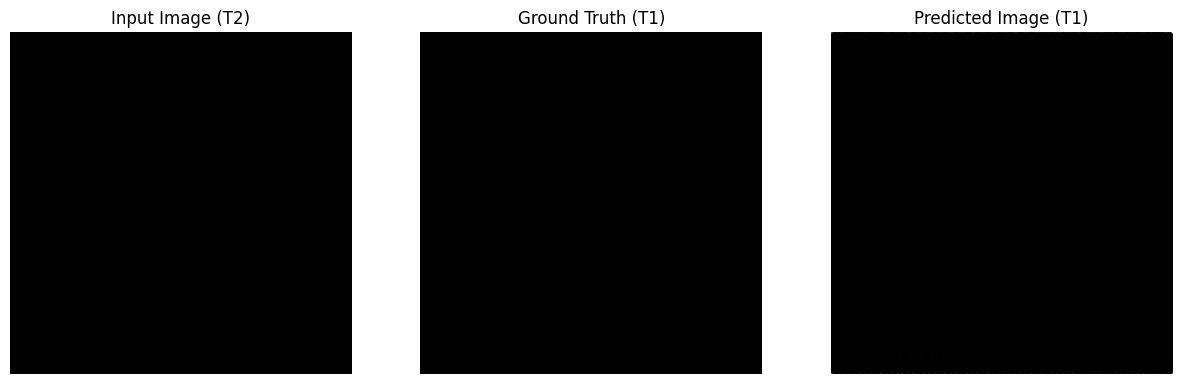

Epoch 86/100 | Step 300
--- Epoch 86 Evaluation ---
PSNR: 24.43
SSIM: 0.7504
----------------------------------------
Epoch 87/100 | Step 300
--- Epoch 87 Evaluation ---
PSNR: 15.83
SSIM: 0.4250
----------------------------------------
Epoch 88/100 | Step 300
--- Epoch 88 Evaluation ---
PSNR: 40.14
SSIM: 0.9575
----------------------------------------
Epoch 89/100 | Step 300
--- Epoch 89 Evaluation ---
PSNR: 41.09
SSIM: 0.9562
----------------------------------------
Epoch 90/100 | Step 300
--- Epoch 90 Evaluation ---
PSNR: 40.34
SSIM: 0.9564
----------------------------------------


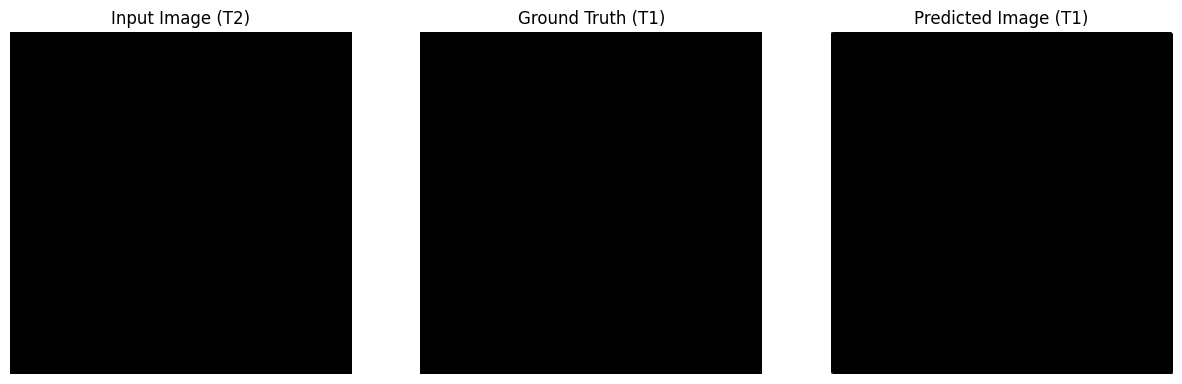

Epoch 91/100 | Step 300
--- Epoch 91 Evaluation ---
PSNR: 37.92
SSIM: 0.9563
----------------------------------------
Epoch 92/100 | Step 300
--- Epoch 92 Evaluation ---
PSNR: 34.19
SSIM: 0.9555
----------------------------------------
Epoch 93/100 | Step 300
--- Epoch 93 Evaluation ---
PSNR: 5.18
SSIM: 0.1404
----------------------------------------
Epoch 94/100 | Step 300
--- Epoch 94 Evaluation ---
PSNR: 14.41
SSIM: 0.4452
----------------------------------------
Epoch 95/100 | Step 300
--- Epoch 95 Evaluation ---
PSNR: 40.17
SSIM: 0.9555
----------------------------------------


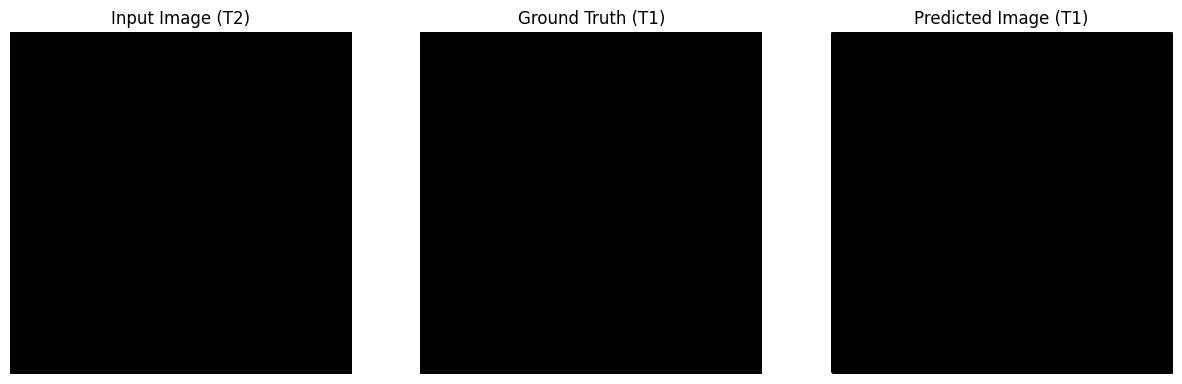

Epoch 96/100 | Step 300
--- Epoch 96 Evaluation ---
PSNR: 26.74
SSIM: 0.8474
----------------------------------------
Epoch 97/100 | Step 300
--- Epoch 97 Evaluation ---
PSNR: 19.81
SSIM: 0.6372
----------------------------------------
Epoch 98/100 | Step 300
--- Epoch 98 Evaluation ---
PSNR: 40.17
SSIM: 0.9567
----------------------------------------
Epoch 99/100 | Step 300
--- Epoch 99 Evaluation ---
PSNR: 7.51
SSIM: 0.1100
----------------------------------------
Epoch 100/100 | Step 300
--- Epoch 100 Evaluation ---
PSNR: 41.79
SSIM: 0.9562
----------------------------------------


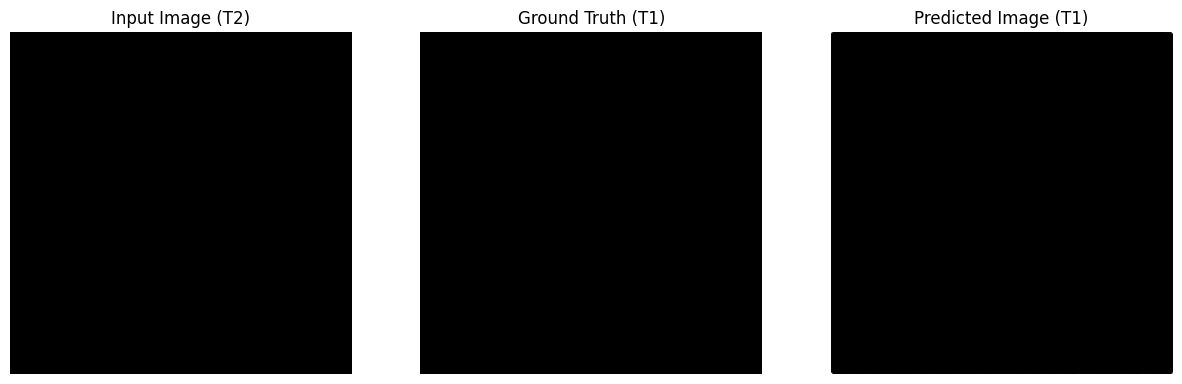

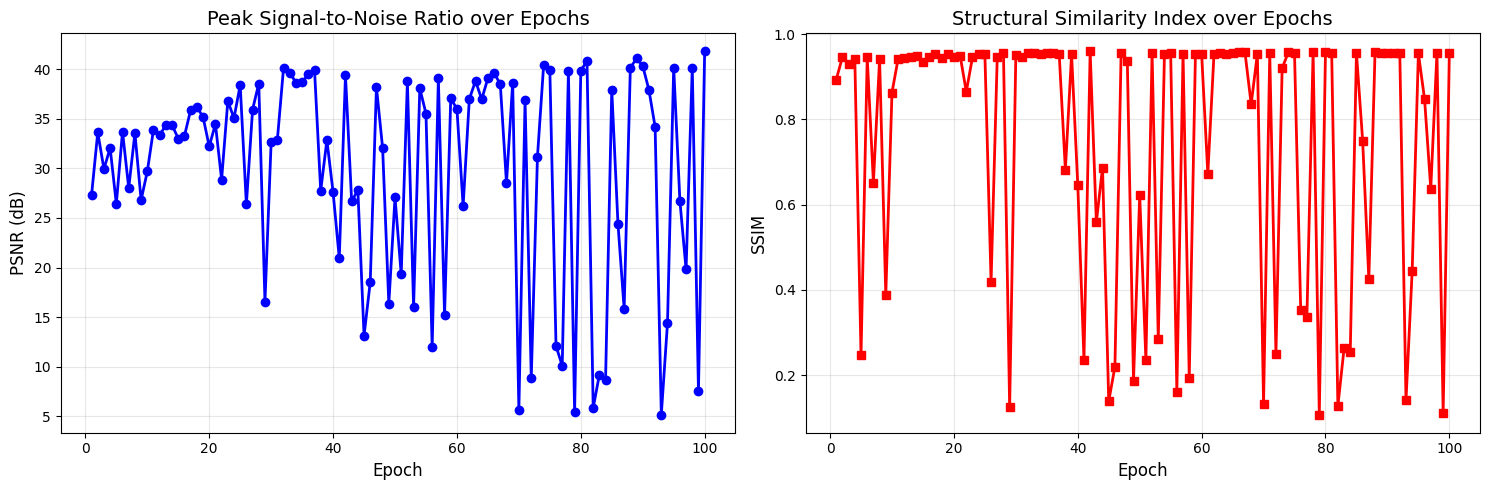


--- Final Comprehensive Evaluation ---


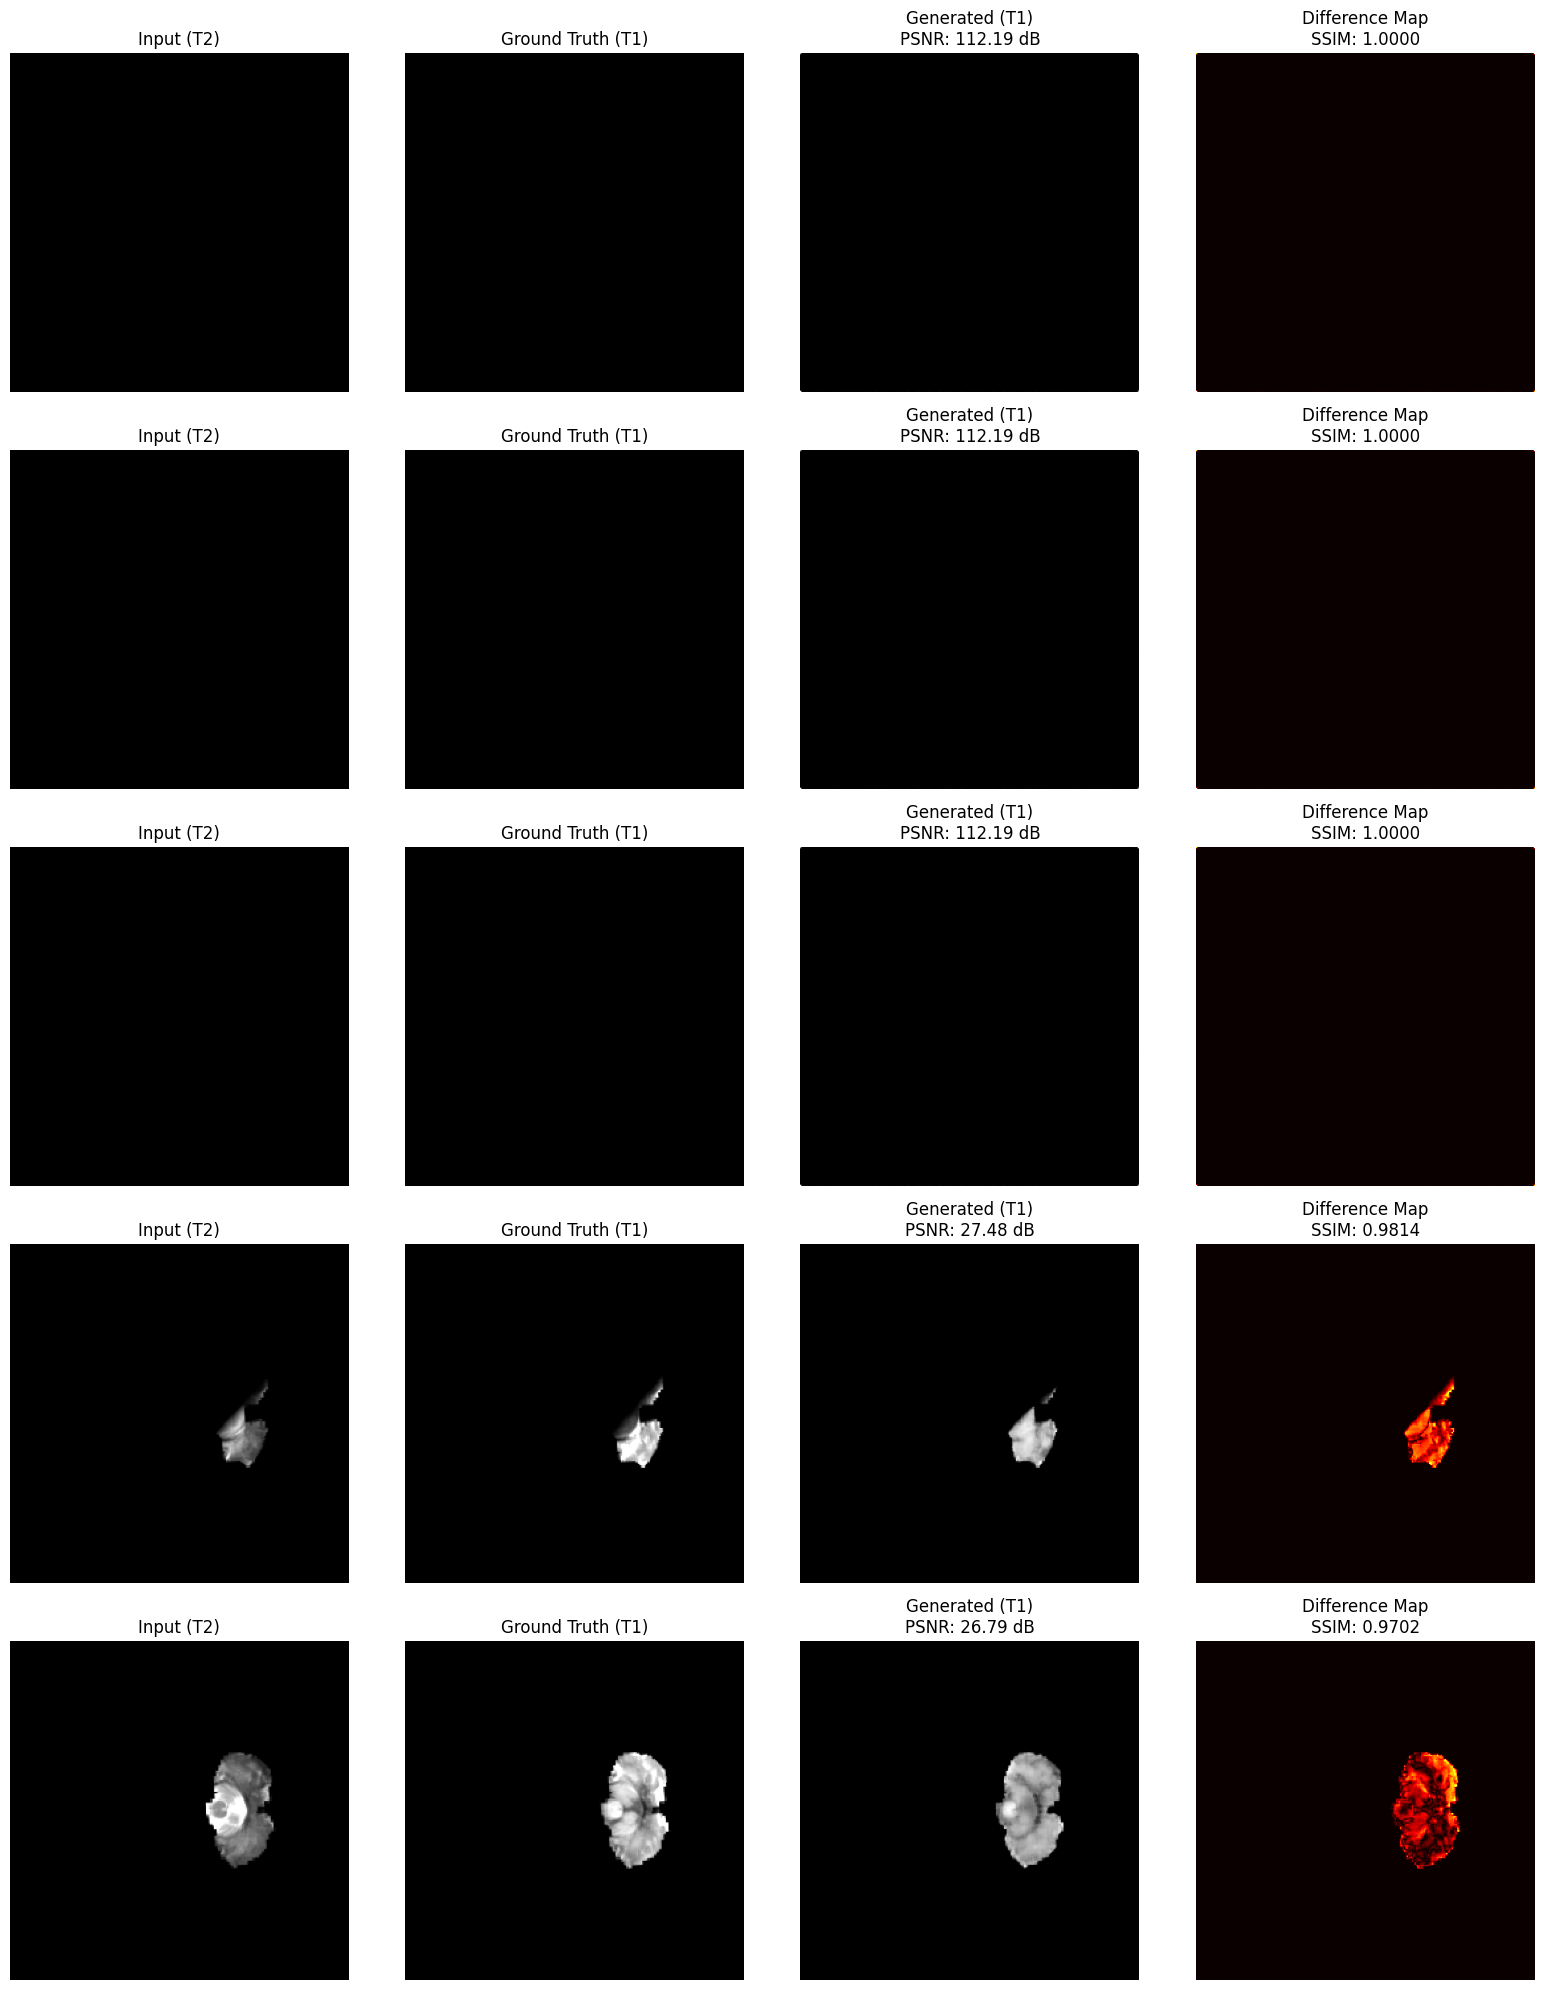


Average PSNR: 78.17 dB
Average SSIM: 0.9903

--- Final Summary for T2 -> T1 ---
Average PSNR: 41.79
Average SSIM: 0.9562
-----------------------------------


In [18]:
# Resetting optimizers to ensure they start fresh for the new task
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# --- TASK 2: T2 -> T1 ---

print("\n\n" + "="*50)
print("--- Running Project 2: T2 -> T1 Synthesis ---")
print("="*50)

# 1. Prepare Data
train_ds_t2_t1, test_ds_t2_t1 = create_dataset(BRAIN_DATA_DIR, task='t2_to_t1', max_patients=PATIENT_LIMIT)

train_dataset_2 = train_ds_t2_t1.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset_2 = test_ds_t2_t1.map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE)

# 2. Define NEW Models for Project 2
generator_t2_t1 = Generator()
discriminator_t2_t1 = Discriminator()

# 3. Train with Visualization (UPDATED)
# We capture the history returned by your new function
psnr_history, ssim_history = fit_with_visualization(
    train_dataset_2, 
    test_dataset_2, 
    EPOCHS, 
    generator_t2_t1, 
    discriminator_t2_t1
)

# 4. Plot Training/Testing Curves (NEW)
# This uses the history captured above to show how metrics improved
plot_training_metrics(psnr_history, ssim_history)

# 5. Comprehensive Final Evaluation (NEW)
# This will show Input vs Ground Truth vs Predicted vs Difference Map
print("\n--- Final Comprehensive Evaluation ---")
evaluate_and_visualize(test_dataset_2, generator_t2_t1, num_samples=5)

# 6. Final Results Summary
final_psnr_2, final_ssim_2 = calculate_metrics(test_dataset_2, generator_t2_t1)

print("\n--- Final Summary for T2 -> T1 ---")
print(f"Average PSNR: {final_psnr_2:.2f}")
print(f"Average SSIM: {final_ssim_2:.4f}")
print("-----------------------------------")


--- Creating Comparison Grid ---


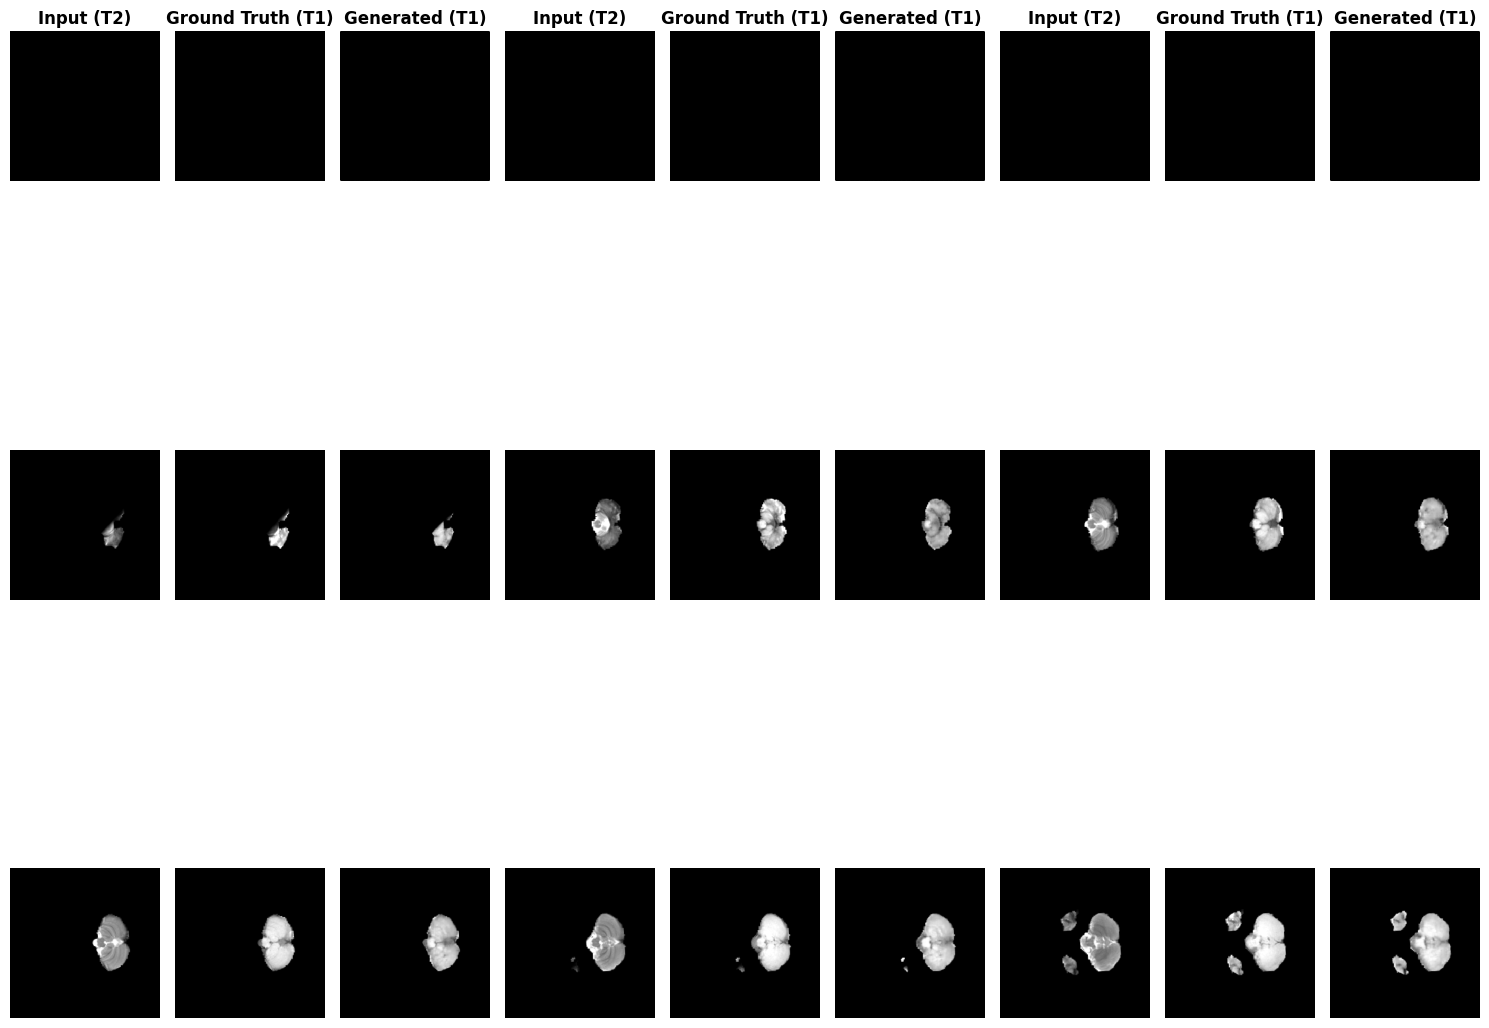

In [19]:
print("\n--- Creating Comparison Grid ---")
create_comparison_grid(test_dataset_2, generator_t2_t1, num_samples=9)


--- Quality Metrics Analysis ---
Calculating metrics for 20 test samples...


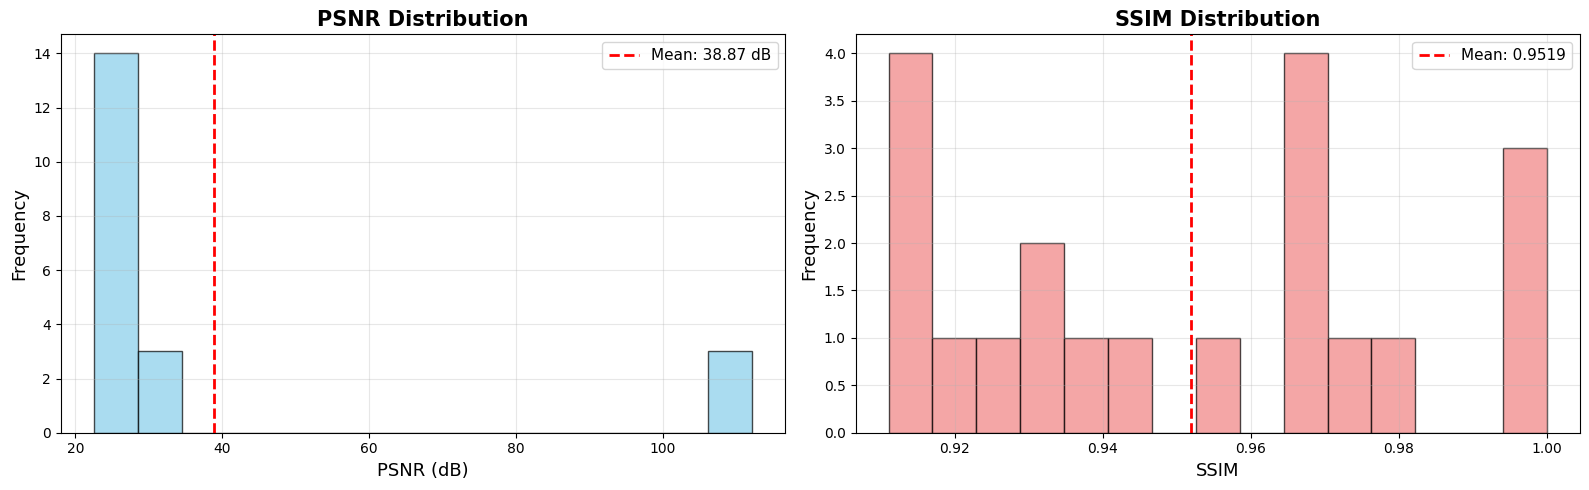


QUALITY METRICS STATISTICS
PSNR: Mean=38.87 dB, Std=30.86 dB
PSNR: Min=22.50 dB, Max=112.19 dB
SSIM: Mean=0.9519, Std=0.0296
SSIM: Min=0.9110, Max=1.0000



In [20]:
print("\n--- Quality Metrics Analysis ---")
visualize_quality_metrics(test_dataset_2, generator_t2_t1, num_samples=20)
